<h1><span style='font-family: "Trebuchet MS", Helvetica, sans-serif;'>Automatic Ticket Classification - EDA
</span></h1>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports

import os
import math
import hjson
import random
import warnings
from time import time
from pathlib import Path
import pandas as pd, numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, Counter
from wordcloud import WordCloud, STOPWORDS
from ftfy import fix_text
from sklearn.preprocessing import LabelEncoder
import tensorflow
from utils.utils import load_hjson
config = load_hjson(Path('./config/config.hjson'))

tqdm.pandas()
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

C:\Users\surya\anaconda3\envs\full\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
# reproducibility
seed = 7
random.seed(seed)
tensorflow.random.set_seed(seed)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Import & Analyse the data.</span></strong></li>
</ul></h3>

In [4]:
dataset = pd.read_excel('./data/input_data.xlsx')
dataset.sample(7)

Short description  \
1263                                 bobj - not working   
6961                               skype does not open.   
18                            erp SID_34 account locked   
5806                  ticket update on ticket_no0434826   
1068                unable to login to windows account    
4795  unable to print production orders : error : pr...   
7325  lcosm005(conformaclad shop_floor_app server):s...   

                                            Description             Caller  \
1263  \r\n\r\nreceived from: ctzykflo.evzbhgru@gmail...  ctzykflo evzbhgru   
6961                               skype does not open.  qftpazns fxpnytmk   
18                            erp SID_34 account locked  nqdyowsm yqerwtna   
5806                  ticket update on ticket_no0434826  fumkcsji sarmtlhy   
1068                unable to login to windows account   mqxkanzt xryzfhpe   
4795  unable to print production orders since last 1...  yjkalmbr jsdyzivq   
7325  lcosm005(conformaclad shop_floor_app server):s...  jloygrwh acvztedi   

     Assignment group  
1263            GRP_0  
6961            GRP_0  
18              GRP_0  
5806            GRP_0  
1068            GRP_0  
4795           GRP_14  
7325            GRP_1

In [5]:
dataset.shape  # very small dataset with only 8500 rows

(8500, 4)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [7]:
# rename column names for convenience
dataset = dataset.rename(columns={
    "Short description": "short_description",
    "Description": "description",
    "Caller": "caller",
    "Assignment group": "group"
    })

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   short_description  8492 non-null   object
 1   description        8499 non-null   object
 2   caller             8500 non-null   object
 3   group              8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [9]:
np.unique(dataset.group), len(np.unique(dataset.group))  # 74 different functional groups

(array(['GRP_0', 'GRP_1', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
        'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
        'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
        'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_3', 'GRP_30',
        'GRP_31', 'GRP_32', 'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36',
        'GRP_37', 'GRP_38', 'GRP_39', 'GRP_4', 'GRP_40', 'GRP_41',
        'GRP_42', 'GRP_43', 'GRP_44', 'GRP_45', 'GRP_46', 'GRP_47',
        'GRP_48', 'GRP_49', 'GRP_5', 'GRP_50', 'GRP_51', 'GRP_52',
        'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56', 'GRP_57', 'GRP_58',
        'GRP_59', 'GRP_6', 'GRP_60', 'GRP_61', 'GRP_62', 'GRP_63',
        'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67', 'GRP_68', 'GRP_69',
        'GRP_7', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73', 'GRP_8', 'GRP_9'],
       dtype=object),
 74)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Check for Incomplete Information</span></strong></li>
</ul></h3>

In [10]:
dataset.isna().sum()  # Few missing values

short_description    8
description          1
caller               0
group                0
dtype: int64

In [11]:
dataset[dataset.isna().any(axis=1)]  # check rows with missing values

short_description  \
2604                       NaN   
3383                       NaN   
3906                       NaN   
3910                       NaN   
3915                       NaN   
3921                       NaN   
3924                       NaN   
4341                       NaN   
4395  i am locked out of skype   

                                            description             caller  \
2604  \r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...  ohdrnswl rezuibdt   
3383  \r\n-connected to the user system using teamvi...  qftpazns fxpnytmk   
3906  -user unable  tologin to vpn.\r\n-connected to...  awpcmsey ctdiuqwe   
3910  -user unable  tologin to vpn.\r\n-connected to...  rhwsmefo tvphyura   
3915  -user unable  tologin to vpn.\r\n-connected to...  hxripljo efzounig   
3921  -user unable  tologin to vpn.\r\n-connected to...  cziadygo veiosxby   
3924  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...  wvqgbdhm fwchqjor   
4341  \r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...  eqmuniov ehxkcbgj   
4395                                                NaN  viyglzfo ajtfzpkb   

       group  
2604  GRP_34  
3383   GRP_0  
3906   GRP_0  
3910   GRP_0  
3915   GRP_0  
3921   GRP_0  
3924   GRP_0  
4341   GRP_0  
4395   GRP_0

In [12]:
dataset.loc[dataset['description'].isna()]

short_description description             caller  group
4395  i am locked out of skype         NaN  viyglzfo ajtfzpkb  GRP_0

In [13]:
dataset.iloc[4395]

short_description    i am locked out of skype
description                               NaN
caller                      viyglzfo ajtfzpkb
group                                   GRP_0
Name: 4395, dtype: object

In [14]:
# imputing the short description by value in description and vice-versa
# However, If both columns were missing, we would have to drop the row
dataset.loc[dataset['description'].isna(), 'description']  = dataset.loc[dataset['description'].isna()].short_description

In [15]:
dataset.loc[dataset['short_description'].isna()]

short_description                                        description  \
2604               NaN  \r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...   
3383               NaN  \r\n-connected to the user system using teamvi...   
3906               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3910               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3915               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3921               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3924               NaN  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...   
4341               NaN  \r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...   

                 caller   group  
2604  ohdrnswl rezuibdt  GRP_34  
3383  qftpazns fxpnytmk   GRP_0  
3906  awpcmsey ctdiuqwe   GRP_0  
3910  rhwsmefo tvphyura   GRP_0  
3915  hxripljo efzounig   GRP_0  
3921  cziadygo veiosxby   GRP_0  
3924  wvqgbdhm fwchqjor   GRP_0  
4341  eqmuniov ehxkcbgj   GRP_0

In [16]:
dataset.loc[dataset['short_description'].isna(), 'short_description']  = dataset.loc[dataset['short_description'].isna()].description

In [17]:
dataset.isna().sum()  # all missing values imputed

short_description    0
description          0
caller               0
group                0
dtype: int64

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Target Class Distribution</span></strong></li>
</ul></h3>

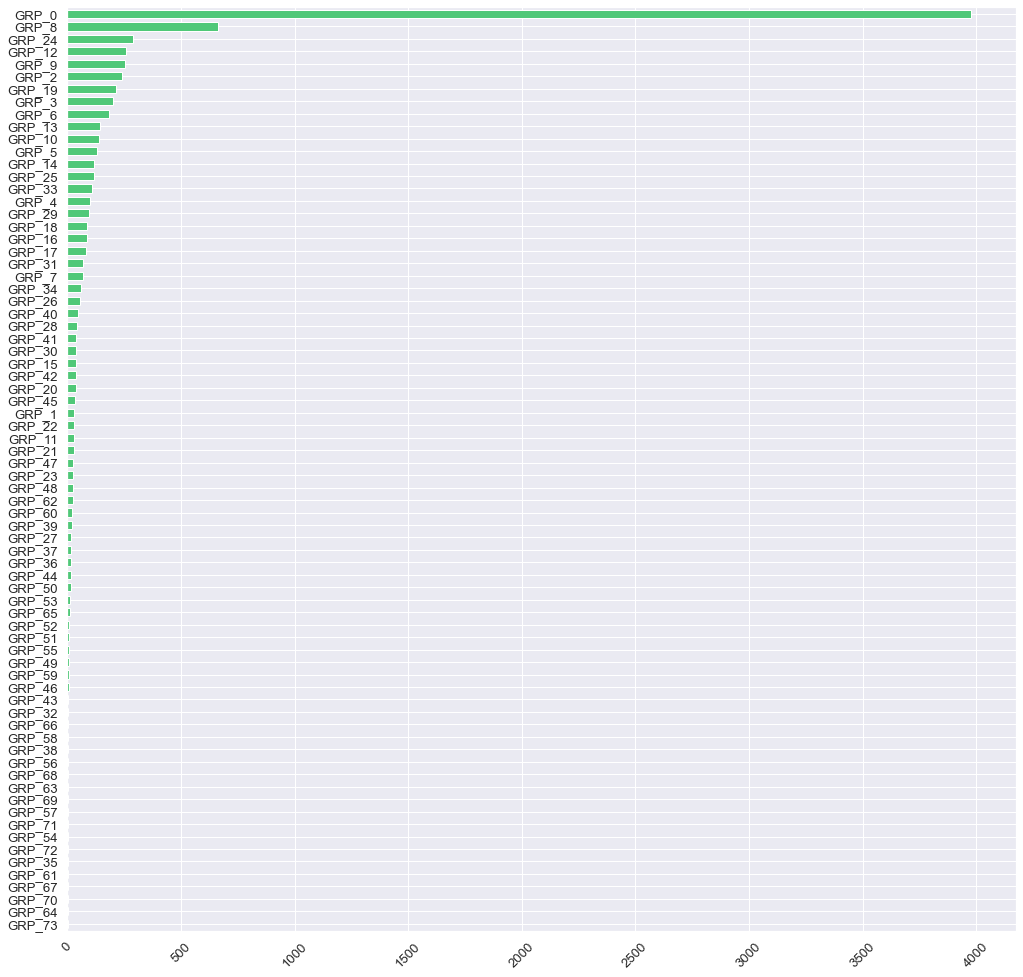

In [18]:
sns.set(font_scale=1.2)  # scale up font size
dataset.group.value_counts().sort_values(ascending=True).plot(kind='barh', width=0.65, figsize=(17, 17), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [19]:
dataset.group.value_counts().sort_values(ascending=False).tail(30)  # few classes with only single-digit datapoints

GRP_36    15
GRP_44    15
GRP_50    14
GRP_53    11
GRP_65    11
GRP_52     9
GRP_51     8
GRP_55     8
GRP_49     6
GRP_59     6
GRP_46     6
GRP_43     5
GRP_32     4
GRP_66     4
GRP_58     3
GRP_38     3
GRP_56     3
GRP_68     3
GRP_63     3
GRP_69     2
GRP_57     2
GRP_71     2
GRP_54     2
GRP_72     2
GRP_35     1
GRP_61     1
GRP_67     1
GRP_70     1
GRP_64     1
GRP_73     1
Name: group, dtype: int64

In [20]:
dataset[dataset.group == 'GRP_70']  # small groups have to merged into a separate "Others" category
dataset[dataset.group == 'GRP_70'].description.tolist()[0]

'an e-mail from  it training has email hints and tips #1.  under "create signature" it has a link "company formatheywting standard" that i am forbidden to see.\n615'

<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>The target class distribution is heavily imbalanced as most calls are assinged to Group 0 and exluding this as well, we find an imabalanced dataset for the rest of the groups.
 </span></ul></h5>

In [21]:
temp = dataset.copy(deep=True)
temp.loc[temp["group"] != 'GRP_0', 'group'] = 'Other'
temp.loc[temp["group"] == 'GRP_0', "group"] = 'Group 0'

In [22]:
temp.group.value_counts()

Other      4524
Group 0    3976
Name: group, dtype: int64

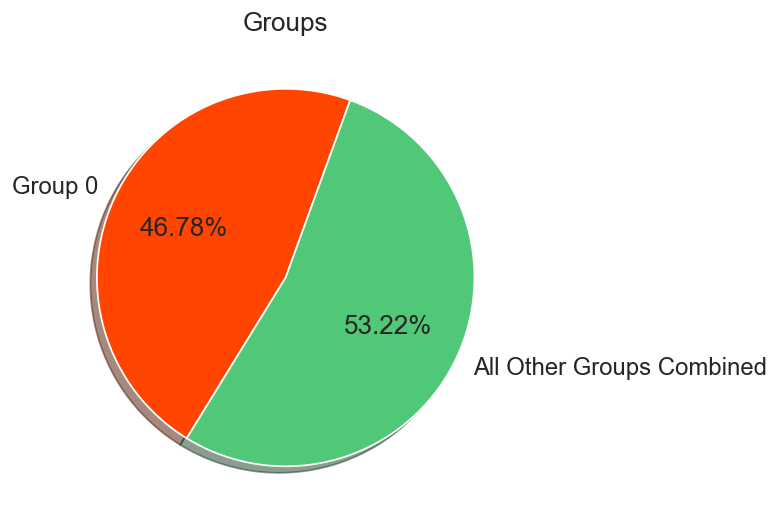

In [23]:
sns.set(font_scale=1.25)  # scale up font size

plt.figure(figsize=(5, 5), dpi=125)
group_0 = len(temp[temp['group'] == 'Group 0'])
others = len(temp[temp['group'] == 'Other'])

plt.pie(x=[group_0, others],
        explode=(0, 0),
        labels=['Group 0', 'All Other Groups Combined'],
        autopct='%1.2f%%',
        shadow=True,
        startangle=70,
        colors=['#FF4500', '#50C878'])

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.title('Groups')
plt.show()

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Choosing a Metric to benchmark model performance</span></strong></li>
</ul></h3>

* This is a multi-class classification problem, where the machine learning model will try to predict if each row is one of the 74 possibilities.
* The majority class is GRP_0, which occurs in 46.78% of the observations.

* The most common metrics for a multi-class classification problem are AUC, F1-score and accuracy.
* Accuracy is not suitable for an imbalanced classification problem. (Note that a model that always predicts GRP_0, will get an accuracy of 46.78%)
* We would choose F1-score if the majority class is more important than the smaller classes.
* We would choose AUC if we also care about the smaller classes.

#### As we want to be able to classify the tickets into all functional groups and functional groups are given equal importance, we choose AUC as the final metric to score model performance.

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Outlier Analysis</span></strong></li>
</ul></h3>

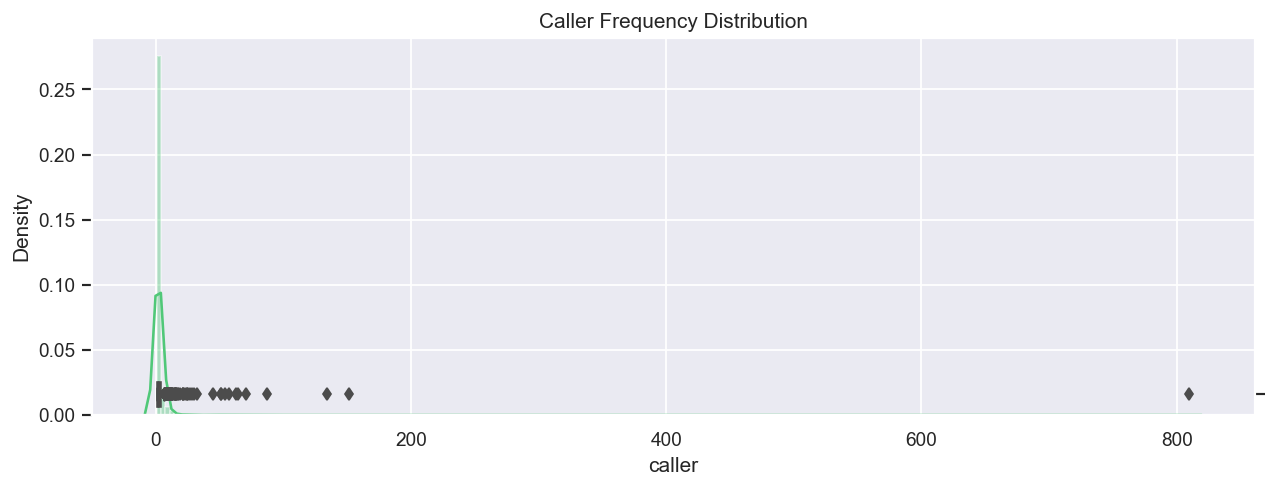

In [24]:
# plotting caller frequency counts
sns.set()
plt.figure(figsize=(12, 4), dpi=125)
ax = sns.distplot(dataset.caller.value_counts(), bins=250, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.caller.value_counts(), color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Caller Frequency Distribution')
plt.show()

In [25]:
dataset[dataset.caller == 'bpctwhsn kzqsbmtp'].group.value_counts()  # most frequent caller

GRP_8     362
GRP_9     153
GRP_5      96
GRP_6      89
GRP_10     60
GRP_60     16
GRP_12      8
GRP_45      7
GRP_1       6
GRP_13      4
GRP_18      3
GRP_47      2
GRP_29      1
GRP_57      1
GRP_44      1
GRP_14      1
Name: group, dtype: int64

In [26]:
dataset[dataset.caller == 'bpctwhsn kzqsbmtp']  # job failure alerts

short_description  \
47    job Job_1424 failed in job_scheduler at: 10/31...   
50    job mm_zscr0099_dly_merktc3 failed in job_sche...   
59    job mm_zscr0099_dly_merktc2 failed in job_sche...   
60    job Job_3181 failed in job_scheduler at: 10/31...   
67    job Job_1338 failed in job_scheduler at: 10/31...   
...                                                 ...   
7053  job Job_1387 failed in job_scheduler at: 08/18...   
7059  job Job_2063b failed in job_scheduler at: 08/1...   
7074  job HostName_1019fail failed in job_scheduler ...   
7076  job HostName_1019fail failed in job_scheduler ...   
7077  job HostName_1019fail failed in job_scheduler ...   

                                            description             caller  \
47    received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
50    received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
59    received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
60    received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
67    received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
...                                                 ...                ...   
7053  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
7059  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
7074  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
7076  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
7077  \r\n\r\nreceived from: monitoring_tool@company...  bpctwhsn kzqsbmtp   

       group  
47     GRP_6  
50     GRP_8  
59     GRP_8  
60     GRP_8  
67     GRP_9  
...      ...  
7053   GRP_9  
7059   GRP_6  
7074   GRP_8  
7076   GRP_8  
7077  GRP_60  

[810 rows x 4 columns]

In [27]:
def get_length(row):
    try:
        row['char_length'] = len(row.description)
        row['word_length'] = len(row.description.split())
        row['short_char_length'] = len(row.short_description)
        row['short_word_length'] = len(row.short_description.split())
    except Exception:  # assign 0 length to missing rows if any
        row['char_length'] = 0
        row['word_length'] = 0
        row['short_char_length'] = 0
        row['short_word_length'] = 0
    return row

dataset = dataset.progress_apply(get_length, axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 8500/8500 [00:26<00:00, 326.70it/s]


In [28]:
dataset.sample(7)

short_description  \
4725                         password expires in 4 days   
2023                                   need this fixed    
4713  job Job_481 failed in job_scheduler at: 09/12/...   
6037  reset passwords for cesgrtar abgrtyreu using p...   
7535  call from debgrtybie savgrtyuille inc1541588 :...   
5187  the dynamics crm url checks is reporting a : d...   
2488  unable to enter an estimated value in opportun...   

                                            description             caller  \
4725  dear all, my password runs out in 4 days, i am...  jxphgfmb gjbtuwek   
2023  \n\nreceived from: oetlgbfw.bsctrnwp@gmail.com...  oetlgbfw bsctrnwp   
4713  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   
6037                                                the  btvmxdfc yfahetsc   
7535  call from debgrtybie savgrtyuille inc1541588 :...  efbwiadp dicafxhv   
5187  observing below alert in monitoring_tool since...  jloygrwh acvztedi   
2488  unable to enter an estimated value in opportun...  wanyrjkg tsycmeof   

       group  char_length  word_length  short_char_length  short_word_length  
4725   GRP_0          172           31                 26                  5  
2023   GRP_0          600           84                 16                  3  
4713   GRP_5          196           22                 61                  8  
6037  GRP_17            3            1                 85                  9  
7535   GRP_0           64            9                 64                  9  
5187  GRP_60          174           21                125                 15  
2488  GRP_22           61           11                 61                 11

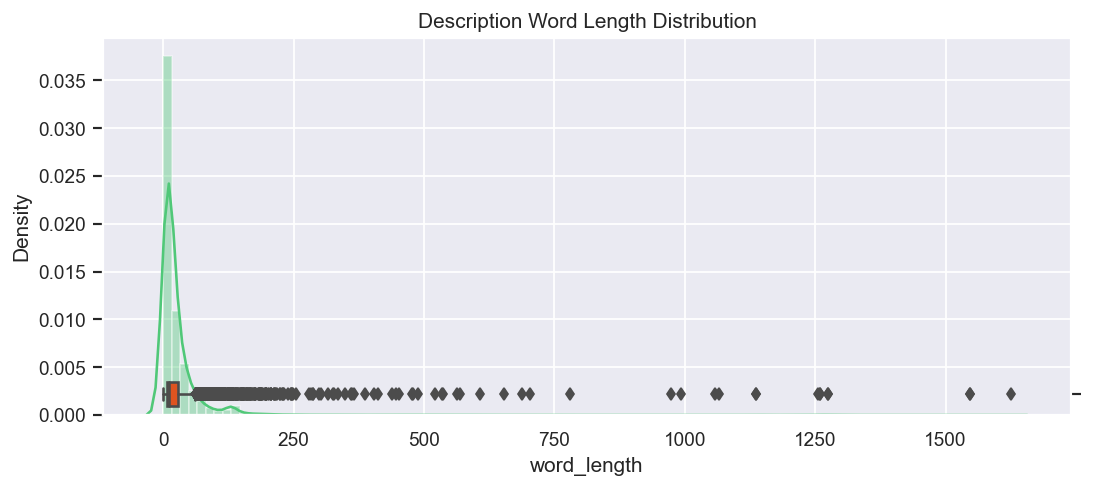

In [29]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.word_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.word_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Description Word Length Distribution')
plt.show()

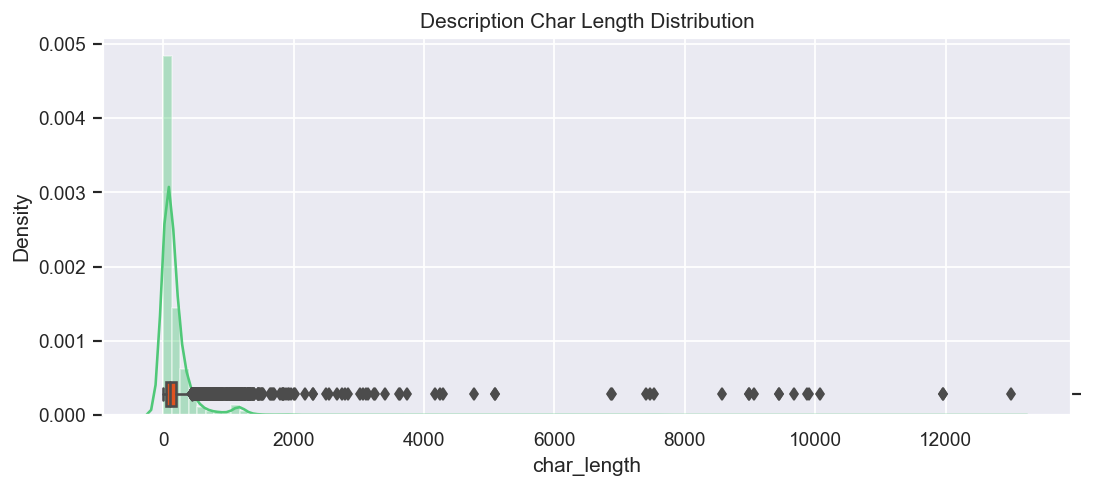

In [30]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.char_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.char_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Description Char Length Distribution')
plt.show()

In [31]:
dataset[dataset.word_length == 0]  # empty description => imputing with the corresponding short_description

short_description description             caller  group  \
6371   authorization add/delete members    \r\n\r\n  hpmwliog kqtnfvrl  GRP_0   
7397                   browser issue :         \r\n  fgejnhux fnkymoht  GRP_0   

      char_length  word_length  short_char_length  short_word_length  
6371            5            0                 33                  3  
7397            2            0                 16                  3

In [32]:
dataset.loc[dataset.word_length == 0, 'description'] = dataset.loc[dataset.word_length == 0]['short_description']
dataset = dataset.progress_apply(get_length, axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 8500/8500 [00:01<00:00, 5837.91it/s]


In [33]:
dataset[dataset.word_length == 0]  # cleaned

Empty DataFrame
Columns: [short_description, description, caller, group, char_length, word_length, short_char_length, short_word_length]
Index: []

In [34]:
dataset[dataset.char_length < 4]  # description 'the' holds no information => imputed with short_description

short_description description  \
1049  reset passwords for soldfnbq uhnbsvqd using pa...         the   
1054  reset passwords for fygrwuna gomcekzi using pa...         the   
1144  reset passwords for wvdxnkhf jirecvta using pa...         the   
1184  reset passwords for pxvjczdt kizsjfpq using pa...         the   
1292  reset passwords for cubdsrml znewqgop using pa...         the   
1476  reset passwords for bnoupaki cpeioxdz using pa...         the   
1558  reset passwords for usa feathers using passwor...         the   
1693  reset passwords for eglavnhx uprodleq using pa...         the   
1834  reset passwords for hybiaxlk lawptzir using pa...         the   
1850  reset passwords for fylrosuk kedgmiul using pa...         the   
1851  reset passwords for fylrosuk kedgmiul using pa...         the   
1860                                                  s           s   
2151  reset passwords for gjisfonb odwfhmze using pa...         the   
2532  reset passwords for qwsjptlo hnlasbed using pa...         the   
2533  reset passwords for qwsjptlo hnlasbed using pa...         the   
2553  reset passwords for bxeagsmt zrwdgsco using pa...         the   
2554  reset passwords for bxeagsmt zrwdgsco using pa...         the   
2572  reset passwords for prgewfly ndtfvple using pa...         the   
2602  reset passwords for wxdvjoct ckxwtoam using pa...         the   
2605  reset passwords for ytzpxhql ntfxgpms using pa...         the   
2749  reset passwords for fkuqjwit jgcsaqzi using pa...         the   
2788  reset passwords for hzmxwdrs tcbjyqps using pa...         the   
3000  reset passwords for knemilvx dvqtziya using pa...         the   
3432                                                dds         dss   
3447  reset passwords for qoybxkfh dwcmxuea using pa...         the   
3692  reset passwords for mvhcoqed konjdmwq using pa...         the   
3693  reset passwords for mvhcoqed konjdmwq using pa...         the   
4055  reset passwords for jerydwbn gdylnaue using pa...         the   
4065  reset passwords for dmexgspl mruzqhac using pa...         the   
4672  reset passwords for robhyertyj f duca using pa...         the   
4978  reset passwords for davidthd robankm using pas...         the   
4984  reset passwords for cubdsrml znewqgop using pa...         the   
4991  reset passwords for davidthd robankm using pas...         the   
5074  reset passwords for mafgtnik -0 using password...         the   
5077  reset passwords for cÃ©sar abreu rghkiriuytes ...         the   
5182  reset passwords for yolktfas fyoxqgvh using pa...         the   
5228  reset passwords for ugawcoye jcfqgviy using pa...         the   
5305  reset passwords for qgilmtyc gmscovxa using pa...         the   
5317  reset passwords for bxeagsmt zrwdgsco using pa...         the   
5482  reset passwords for qycgdfhz iqshzdru using pa...         the   
5708  reset passwords for bxeagsmt zrwdgsco using pa...         the   
5839  reset passwords for cpmaidhj elbaqmtp using pa...         the   
5884  reset passwords for bxeagsmt zrwdgsco using pa...         the   
6037  reset passwords for cesgrtar abgrtyreu using p...         the   
6058  reset passwords for bxeagsmt zrwdgsco using pa...         the   
6693  reset passwords for pzjelyxg vstyaouc using pa...         the   
6764  reset passwords for horeduca ogrhivnm using pa...         the   
6819  reset passwords for wvdxnkhf jirecvta using pa...         the   
6963  reset passwords for patrcja szpilewska using p...         the   
7131  reset passwords for ezrsdgfc hofgvwel using pa...         the   
7132  reset passwords for ezrsdgfc hofgvwel using pa...         the   
7169  reset passwords for andrdgrtew p taneghrty usi...         the   
7630  reset passwords for jcmxerol nbfyczqr using pa...         the   
7875  reset passwords for esias bosch using password...         the   
8059  reset passwords for wptbgchj jutpdcqf using pa...         the   
8092  reset passwords for prgthyuulla ramdntythanjes...       

In [35]:
dataset[dataset.description == 's']  # holds no actual information with just one letter, has to be dropped

short_description description             caller  group  char_length  \
1860                 s           s  gzjtweph mnslwfqv  GRP_0            1   

      word_length  short_char_length  short_word_length  
1860            1                  1                  1

In [36]:
# drop row with description: 's'
dataset.drop(dataset[dataset.description == 's'].index, inplace=True)
dataset = dataset.progress_apply(get_length, axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 8499/8499 [00:01<00:00, 5214.11it/s]


In [37]:
# description 'the' holds no information => imputed with corresponding short_description
dataset.loc[dataset.description == 'the', 'description'] = dataset.loc[dataset.description == 'the']['short_description']
dataset = dataset.progress_apply(get_length, axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 8499/8499 [00:01<00:00, 5308.56it/s]


In [38]:
# Single Word descriptions
dataset[dataset.word_length == 1].shape

(41, 8)

In [39]:
# dataset[dataset.word_length == 1].to_csv('./data/Single_Word_Descriptions.csv')
dataset[dataset.word_length == 1].sample(20)  # these have to be cleaned up and imputed later on

short_description  \
618                                    outlookæ‰“ä¸å¼€   
8266         erpæ— æ³•è¿›è¡Œé‡‡è´­ï¼ˆè½¬ç»™è´ºæ­£å¹³ï¼‰   
6253  in the inbox always show there are several ema...   
5146                                 walkmeåŠ è½½æ•…éšœ   
1955                     æœ‰ä¸€ä¸ªé“¾æŽ¥æ–‡ä»¶æ‰“ä¸å¼€   
4569  i am not able to connect to my regular printer...   
1178                              ç”µè¯æœºæ²¡æœ‰å£°éŸ³   
7302                               skypeä¼šè®®æ—¶ä¸åŽ»   
7588                                    æ˜¾ç¤ºå™¨ä¸äº®   
5491                    é›»è…¦å‡ºç¾è—å±,ç„¡æ³•é–‹æ©Ÿ   
4501                  åˆ¶ç²‰ä¸‰æ¥¼æŽ§åˆ¶å®¤ç”µè„‘æ•…éšœ   
1954                        ç¬”è®°æœ¬é‡æ–°è£…ä¸‹ç³»ç»Ÿ   
4098  ç”µè„‘æ„å¤–è¿›æ°´ï¼Œå¸®åŠ©å¤„ç†ï¼è¯·äº¤å°è...   
2267  urgent help required- outlook to crm mfg_toolt...   
1704                                    è´¦æˆ·è¢«é”å®š   
4503                        ç”¨å‹å®šæœŸå¤‡ä»½ä¸æˆåŠŸ   
1452            è€ƒå‹¤ç³»ç»Ÿè¿›ä¸åŽ»è¯·å¤„ç†è°¢è°¢ï¼   
2915             websites not loading on company center   
5147                                 ç”µè„‘å¼€æœºæ•…éšœ   
5891                  vpnä¸èƒ½ä½¿ç”¨ï¼Œè¯·è½¬ç»™å°è´º   

                                            description             caller  \
618   æ‰“å¼€outlookæ—¶ï¼Œæ˜¾ç¤ºoutlook.ostæ–‡ä»¶é”™è...  qayozbcd vwglmpjq   
8266  è¿›è¡Œé‡‡è´­æ—¶æ˜¾ç¤º"æ‰¾ä¸åˆ°å‘˜å·¥111115483...  kyagjxdh dmtjpbnz   
6253                                              +86    mqbxwpfn uclrqfxa   
5146  walkmeä¸‹è½½å®‰è£…åŽï¼ŒæŒ‰é’®ä¸èƒ½åœ¨æµè§ˆå...  whflryeb fatgdzhq   
1955      æœ‰ä¸€é“¾æŽ¥æ–‡ä»¶æ‰“ä¸å¼€ï¼Œæç¤ºç‰ˆæœ¬ä½Ž  qsfcxzel quwykhno   
4569                                             x5380   koiapqbg teyldpkw   
1178                              ç”µè¯æœºæ²¡æœ‰å£°éŸ³  cyjlqdwm kywiuosn   
7302       skypeä¼šè®®ä»Žé‚®ç®±é‡Œçš„é“¾æŽ¥è¿›ä¸åŽ»ã€‚  rekpvblc ufysatml   
7588            æ—©ä¸Šå¼€æœºåŽæ˜¾ç¤ºå™¨ä¸å‡ºå›¾åƒã€‚  wgmqlnzh vpebwoat   
5491  é€£vpnæ™‚,ç„¡æ³•é€£ä¸Šå¾Œ,é‡è©¦å¾Œ,çªç„¶å‡ºç...  zhpwcdea cboefuis   
4501  åˆ¶ç²‰ä¸‰æ¥¼æŽ§åˆ¶å®¤ç”µè„‘ä¸èƒ½å¼€å¯ï¼Œç”µæ...  agyvbnwz mxsonkdc   
1954               æŠŠæˆ‘çš„ç¬”è®°æœ¬é‡æ–°è£…ä¸‹ç³»ç»Ÿ  xjvubmlq vyamhjip   
4098  ç”µè„‘æ„å¤–è¿›æ°´ï¼Œå¸®åŠ©å¤„ç†ï¼è¯·äº¤å°è...  pvfclkmn gebyipwr   
2267                                           contact   gonflcmq wmptisvz   
1704                  ç”¨æˆ·è´¦æˆ·é”å®šï¼Œè¯·æ±‚è§£é”  yvscpgax wdfxytzu   
4503  æœåŠ¡å™¨ç«¯ç”¨å‹ç³»ç»Ÿæœ€è¿‘åŠä¸ªæœˆæ—¥å¤‡ä...  igdnsjhz awnftgev   
1452            è€ƒå‹¤ç³»ç»Ÿè¿›ä¸åŽ»è¯·å¤„ç†è°¢è°¢ï¼  spgdcvhb ocagnpmj   
2915                          companycenter.company.com  qcfmxgid jvxanwre   
5147  åŽŸææ–™ä»“åº“ç”µè„‘å¼€æœºè“å±ï¼Œä¸»æœºé¢æ...  ycjxrsba ehftdorm   
5891                  vpnä¸èƒ½ä½¿ç”¨ï¼Œè¯·è½¬ç»™å°è´º  ehfvwltg eakjbtoi   

       group  char_length  word_length  short_char_length  short_word_length  
618    GRP_0           72            1                 16                  1  
8266  GRP_30           84            1                 42                  2  
6253   GRP_0            5            1                 94                 19  
5146  GRP_48           60            1                 18                  2  
1955  GRP_30           45            1                 30                  1  
4569   GRP_0            6            1                 84                 16  
1178  GRP_30           21            1                 21                  1  
7302  GRP_30           44            1                 20                  1  
7588  GRP_30           39            1                 15                  1  
5491  GRP_31           67            1                 31                  1  
4501  GRP_48           72            1                 33                  1  
1954  GRP_30           36            1                 27                  1  
4098  GRP_30           57            1                 57                  1  
2267   GRP_0            8            1               

In [40]:
dataset[dataset.word_length == 2].sample(20)

short_description  \
146                             erp_print_tool install.   
1480                                     password reset   
2875                                         blank call   
5973                                   outlook freezes.   
423                                     account locked.   
1154                                     reset password   
2334                                   password expired   
4029                                     accout locked    
3400                                    account locked.   
4951                                        german call   
6907                      collaboration_platform query    
5288  i'm on vacation, and my vpn isn't working.  ca...   
3096                             unable to login to erp   
1525                                    account locked.   
6496                                installing cutview    
3026                                     password reset   
4952                                     password reset   
6440                                     account unlock   
3772                                     account unlock   
3672                                    account locked.   

                        description             caller   group  char_length  \
146         erp_print_tool install.  aorthyme rnsuipbk   GRP_0           23   
1480                 password reset  rhpqxsuy vcukgdfe   GRP_0           14   
2875                     blank call  pwkrlqbc zslqfmka   GRP_0           10   
5973               outlook freezes.  rwhavckz drvxyihj   GRP_0           16   
423                 account locked.  bkyphsgq cfyksehu   GRP_0           15   
1154                 reset password  vzqomdgt jwoqbuml  GRP_12           14   
2334               password expired  uyhceqzr tpbdwiyv   GRP_0           16   
4029                 accout locked   afijkocw rjtxslpa   GRP_0           14   
3400                account locked.  vyjmlain hvjbmdgi   GRP_0           15   
4951                    german call  rbozivdq gmlhrtvp   GRP_0           11   
6907  collaboration_platform query   pytmhcxq cswovnax   GRP_0           29   
5288                          , vpn  koiapqbg teyldpkw  GRP_50            5   
3096             misplaced password  uaclgmeq hyxzmwdi   GRP_0           18   
1525                account locked.  ndrtahvm kjhdybzm   GRP_0           15   
6496            installing cutview   sgqthwuf cyahpdfu  GRP_66           19   
3026                 password reset  dvncgqek skvcrebq   GRP_0           14   
4952                 password reset  alfqhigv zofjibkr   GRP_0           14   
6440                 account unlock  dhraxivp enmfvuqb   GRP_0           14   
3772                 account unlock  opzuciql muedfkhz   GRP_0           14   
3672                account locked.  znyijvpg kjqhrwlv   GRP_0           15   

      word_length  short_char_length  short_word_length  
146             2                 23                  2  
1480            2                 14                  2  
2875            2                 10                  2  
5973            2                 16                  2  
423             2                 15                  2  
1154            2                 14                  2  
2334            2                 16                  2  
4029            2                 14                  2  
3400            2                 15                  2  
4951            2                 11                  2  
6907            2                 29                  2  
5288            2                 68                 14  
3096            2                 22                  5  
1525            2                 15                  2  
6496            2                 19                  2  
3026            2                 14                  2  
4952            2                 14                  2  
6440            2                 14                  2  
3772            2                 14

In [41]:
dataset[dataset.short_word_length == 0]  # all have short descriptions

Empty DataFrame
Columns: [short_description, description, caller, group, char_length, word_length, short_char_length, short_word_length]
Index: []

In [42]:
dataset[dataset.short_char_length < 3]

short_description                                        description  \
3529                PR  create a purchase requisition with purchasing ...   

                 caller   group  char_length  word_length  short_char_length  \
3529  ejvkzobl yijgokrn  GRP_29          201           31                  2   

      short_word_length  
3529                  1

In [43]:
dataset[dataset.char_length < 4]  

short_description description             caller  group  char_length  \
3432               dds         dss  onctqhsg cpahzsle  GRP_0            3   

      word_length  short_char_length  short_word_length  
3432            1                  3                  1

In [44]:
dataset[dataset.word_length > 800]  # security incident logs

short_description  \
3530  security incidents - ( #in33944691 ) : possibl...   
3965  security incidents - ( #in33809307 ) : possibl...   
4087  security incidents - ( sw #in33895560 ) : mage...   
4089  security incidents - ( sw #in33895560 ) : mage...   
5092  security incidents - ( #in33578632) : suspicio...   
5433  security incidents - ( #in33765965 ) : possibl...   
7345  security incidents - ( sw #in33501789 ) : broa...   
7647  security incidents - ( #in33578632) : suspicio...   
7982  security incidents - ( dsw #in33390850 ) : sus...   
7984  security incidents - ( dsw #in33390850 ) : sus...   
7989  security incidents - ( dsw #in33407676 ) : tra...   
7995  security incidents - ( dsw #in33407676 ) : tra...   
7997  security incidents - ( sw #in33544563 ) : poss...   
8002  security incidents - ( sw #in33544563 ) : poss...   

                                            description             caller  \
3530  source ip: 195.272.28.222\nsource port: 80\nso...  gzhapcld fdigznbk   
3965  source ip :195.22.28.222 \nsystem name :androi...  gzhapcld fdigznbk   
4087  source ip : 172.20.10.37 , 208.211.136.158\nsy...  ugyothfz ugrmkdhx   
4089  source ip : 172.20.10.37 , 208.211.136.158\nsy...  ugyothfz ugrmkdhx   
5092  source ip: 29.26.13.3095\r\nsource hostname: H...  gzhapcld fdigznbk   
5433  source ip :10.40.6.221\nsystem name :rqxl85172...  gzhapcld fdigznbk   
7345  we are seeing activity indicating the host at ...  ugyothfz ugrmkdhx   
7647  source ip :\r\nsystem name :\r\nuser  name:\r\...  gzhapcld fdigznbk   
7982  source ip : 78.83.16.293\nsystem name : HostNa...  ugyothfz ugrmkdhx   
7984  source ip : 78.83.16.293\r\nsystem name : Host...  ugyothfz ugrmkdhx   
7989  source ip : 61.01.52.02617\r\nsystem name : lp...  ugyothfz ugrmkdhx   
7995  source ip : 61.01.52.02617\r\nsystem name : lp...  ugyothfz ugrmkdhx   
7997  source ip : 45.25.35.0499\nsystem name : lpal9...  ugyothfz ugrmkdhx   
8002  source ip : 45.25.35.0499\r\nsystem name : lpa...  ugyothfz ugrmkdhx   

       group  char_length  word_length  short_char_length  short_word_length  
3530   GRP_2         7524          974                111                 17  
3965   GRP_2         8988         1255                116                 17  
4087  GRP_39        11968         1547                 63                 11  
4089   GRP_2        11968         1547                 63                 11  
5092   GRP_3         9063         1066                 92                 11  
5433   GRP_2         8575         1057                 83                 13  
7345   GRP_2        13001         1625                102                 14  
7647   GRP_2         8991          993                 92                 11  
7982   GRP_2         9881         1137                118                 17  
7984  GRP_12        10077         1137                118                 17  
7989   GRP_2         9440         1275                109                 18  
7995  GRP_62         9440         1275                109                 18  
7997   GRP_2         9678         1260                107                 16  
8002  GRP_62         9912         1260                107                 16

In [45]:
dataset[dataset.word_length > 200][dataset.word_length < 800]

short_description  \
238   erp pi and msd crm connectivity issue- serirtc...   
239                 printer problem / issue information   
981   employment status - new non-employee ycgkinov ...   
1175  bitte das iphone-6 001 freischalten fÃ¼r mail-...   
1179  media server disconnect lpapr952(south_amerirt...   
1577  the printer is defaulting to the usa printer f...   
1696  mm:pur_req_ko assign for user: yeyhtung kimthy...   
1812  sales orders are not updating with correct del...   
1855  printer problem / issue information -- zebra l...   
2082        printing language sa38 (reporting rfumsv00)   
2370  update inwarehouse_tool documents from list fo...   
2445  vh 27 - werk germany - fehlende druckauftrÃ¤ge...   
2492  printing request - request transaction print t...   
2741  i have lost my access to reporting_tool in crm...   
2879                           mobile device activation   
2978  security incidents - ( #in33987594) : 29866 vi...   
3097  security incidents - ( #in33976733) : suspicio...   
3098  security incidents - ( #in33984033) : internal...   
3165  partial confirmation info sent to erp but mach...   
3325                                            it help   
3382                                       support with   
3532  security incidents - ( #in33944327) :possible ...   
3705  security incidents - ( #in33932723 ) : possibl...   
3706  security incidents - ( #in33924718 ) : possibl...   
3718                     re: need a little help--please   
3961  security incidents - ( #in33805815) : possible...   
4382                printer problem / issue information   
4730  security incidents - (  #in33847938) : possibl...   
4825   incident #in33541962 - phishing form submit -...   
4853         bahdqrcs xvgzdtqj's onbankrding experience   
4886  security incidents - ( #in33826812 ) : possibl...   
4893  security incidents - ( #in33826812 ) : possibl...   
5072  erp-step interface programdnty not sending all...   
5204  employment status - three new non-employee [en...   
5394                                              hana    
5485               printer problem / issue information    
5503                                     dsw in22210104   
5504   incident #in33541962 - phishing form submit -...   
5506                                     dsw in22457494   
5507  possible vulnerability scan from host.my-tss.c...   
5697                printer problem / issue information   
5787  windows asks to install driver and then won't ...   
6017     open order schedule lines_p2016-08-28-22-03-54   
6734  security incidents - ( dsw incident no ) : sus...   
6888  security incidents - (#in33655554) : errata se...   
6931  '51551 vid67965 microsoft windows httpsys rce ...   
7163  symantec endpoint encryption (see) agent roll ...   
7331  security incidents - ( #in33505432 ) : repeat ...   
7338  security incidents - ( #in33505432 ) : repeat ...   
7433  zpdist_programdnty not allowing to distribute ...   
7553                    wifi slow speed-company (apac)    
7981  as per inc1530176::security incidents - (in335...   
7987  security incidents - (in33536629) : possible t...   
7991  as per inc1530161::security incidents - ( in33...   
7996  security incidents - ( in33490582 ) : suspicio...   
8160                                  release of device   
8232  stepfhryhan needs access to below collaboratio...   
8339     unlock account  email  in cell phone the users   

                                            description             caller  \
238   hi all\n\nwe have a connectivity issue between...  kgytujhe bonhwzrx   
239   please complete all required questions below. ...  dzjxrkae grqczsmx   
981   *page down to ensure that all required data fi...  lfikjasz tjbqcmvl   
1175  \n\nreceived from: rtnyumbg.yzemkhbq@gmail.com...  rtnyumbg yzemkhbq   
1179  received below email from inin tried to ping t...  jloygrwh acvztedi   
1577  from: kryuisti turleythy \nsent: wednesday, oc...  hybiaxlk lawptzir   
1696  mm:p

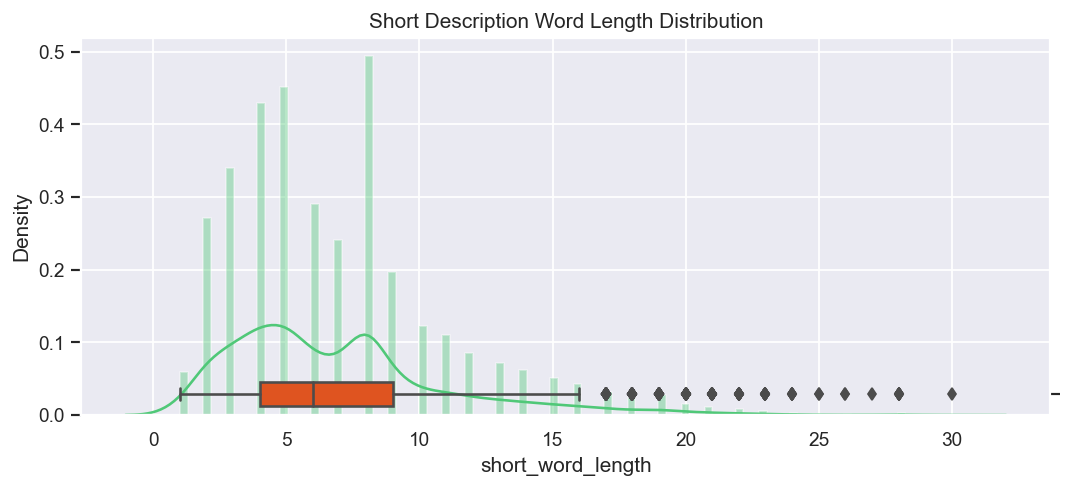

In [46]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.short_word_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.short_word_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Short Description Word Length Distribution')
plt.show()

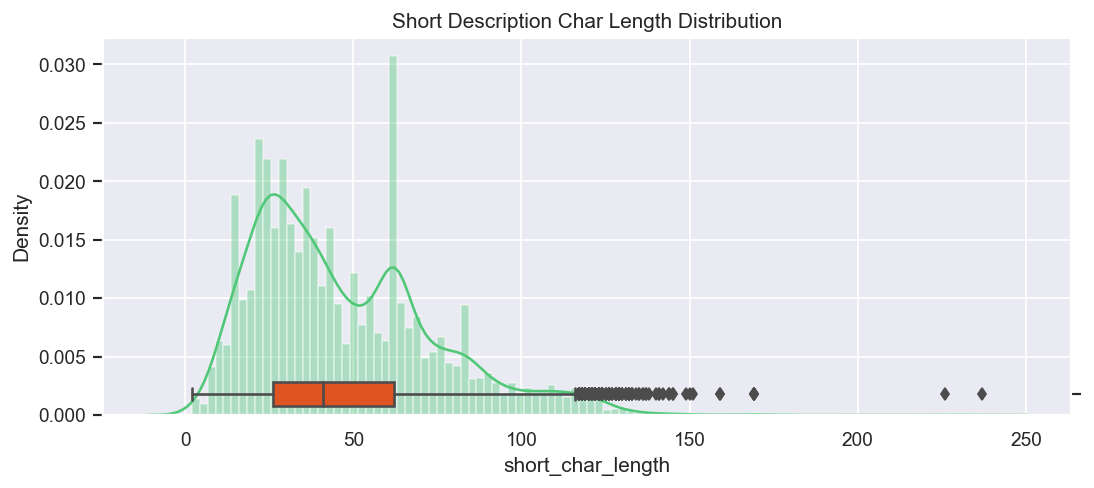

In [47]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.short_char_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.short_char_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Short Description Char Length Distribution')
plt.show()

In [48]:
dataset.describe()

char_length  word_length  short_char_length  short_word_length
count   8499.000000  8499.000000        8499.000000        8499.000000
mean     204.595246    27.331804          47.386751           6.951759
std      519.530803    65.026307          27.323700           4.158631
min        3.000000     1.000000           2.000000           1.000000
25%       42.000000     6.000000          26.000000           4.000000
50%      106.000000    11.000000          41.000000           6.000000
75%      201.000000    28.000000          62.000000           9.000000
max    13001.000000  1625.000000         237.000000          30.000000

<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Most descriptions have between 6 and 28 words long with median at 41 (106 characters) and mean at 27.2 with relatively few outliers ranging till 1625 words!<br>
    <li>Most Short descriptions have between 4 and 9 words long with median at 6 (41 characters) and mean at 6.92 with relatively few outliers ranging till 28 words.<br>
 </span></ul></h5>

In [49]:
def clean_nonsensible_outliers():
    # impute the zero length description with corresponding short description
    dataset.loc[dataset.word_length == 0, 'description'] = dataset.loc[dataset.word_length == 0]['short_description']
     # drop row with description: 's'
    dataset.drop(dataset[dataset.description == 's'].index, inplace=True)
    # description 'the' holds no information => imputed with corresponding short_description
    dataset.loc[dataset.description == 'the', 'description'] = dataset.loc[dataset.description == 'the']['short_description']

# clean_nonsensible_outliers()

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Fix Text Encoding</span></strong></li>
</ul></h3>

In [50]:
dataset[dataset.word_length == 1].sample(20)

short_description  \
3432                                                dds   
3738                                       ç”µè¯æ•…éšœ   
618                                    outlookæ‰“ä¸å¼€   
1954                        ç¬”è®°æœ¬é‡æ–°è£…ä¸‹ç³»ç»Ÿ   
7588                                    æ˜¾ç¤ºå™¨ä¸äº®   
7317                                       ç”µè„‘æ•…éšœ   
608   etiketten drucker im bereich endkontrolle germ...   
1452            è€ƒå‹¤ç³»ç»Ÿè¿›ä¸åŽ»è¯·å¤„ç†è°¢è°¢ï¼   
3120               ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚   
6106                                 ç”µè„‘ä¸èƒ½å¼€æœº   
4098  ç”µè„‘æ„å¤–è¿›æ°´ï¼Œå¸®åŠ©å¤„ç†ï¼è¯·äº¤å°è...   
4505   request to reset microsoft online services pa...   
5891                  vpnä¸èƒ½ä½¿ç”¨ï¼Œè¯·è½¬ç»™å°è´º   
7969               å®¢æˆ·æä¾›çš„åœ¨çº¿ç³»ç»Ÿæ‰“ä¸å¼€   
5146                                 walkmeåŠ è½½æ•…éšœ   
1081                                 ç”¨å‹è½¯ä»¶é—®é¢˜   
2267  urgent help required- outlook to crm mfg_toolt...   
5761                                 ä¸»æœºä¸èƒ½å¼€å¯   
6534                  æ¶‚å±‚ã€ç®¡ä¸è½¦é—´ç”µè¯æ•…éšœ   
5311                       ç³»ç»Ÿæ•…éšœï¼Œå¯åŠ¨è“å±.   

                                            description             caller  \
3432                                                dss  onctqhsg cpahzsle   
3738                é“¸æ£’è½¦é—´ç”µè¯æ•…éšœï¼Œ39523850  sbkhjigv pbvlfcse   
618   æ‰“å¼€outlookæ—¶ï¼Œæ˜¾ç¤ºoutlook.ostæ–‡ä»¶é”™è...  qayozbcd vwglmpjq   
1954               æŠŠæˆ‘çš„ç¬”è®°æœ¬é‡æ–°è£…ä¸‹ç³»ç»Ÿ  xjvubmlq vyamhjip   
7588            æ—©ä¸Šå¼€æœºåŽæ˜¾ç¤ºå™¨ä¸å‡ºå›¾åƒã€‚  wgmqlnzh vpebwoat   
7317  è´¨æŽ§éƒ¨æ‹‰åŠ›è¯•éªŒæœºæŽ§åˆ¶ç”µè„‘çš„æ“ä½œç...  kwpzbxvf cvuhoizx   
608                                   funktionsstÃ¶rung  tzmewbdv zjbuwmkn   
1452            è€ƒå‹¤ç³»ç»Ÿè¿›ä¸åŽ»è¯·å¤„ç†è°¢è°¢ï¼  spgdcvhb ocagnpmj   
3120               ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚  ruhbyzpv vlksnjti   
6106                     æ—©ä¸Šä¸Šç­ç”µè„‘æ‰“ä¸å¼€ã€‚  mzerdtop xnlytczj   
4098  ç”µè„‘æ„å¤–è¿›æ°´ï¼Œå¸®åŠ©å¤„ç†ï¼è¯·äº¤å°è...  pvfclkmn gebyipwr   
4505                                      \r\n\r\nkind   rcfwnpbi kvhedyrc   
5891                  vpnä¸èƒ½ä½¿ç”¨ï¼Œè¯·è½¬ç»™å°è´º  ehfvwltg eakjbtoi   
7969  å®¢æˆ·æä¾›çš„åœ¨çº¿é€è´§å•ç”Ÿæˆç³»ç»Ÿæ‰“ä...  fupikdoa gjkytoeh   
5146  walkmeä¸‹è½½å®‰è£…åŽï¼ŒæŒ‰é’®ä¸èƒ½åœ¨æµè§ˆå...  whflryeb fatgdzhq   
1081  æ‰“å¼€å·²å…³é—­çš„é”€å”®è®¢å•æ—¶ï¼Œæ˜¾ç¤º"ä¸...  bwstnmjh yqumwrsk   
2267                                           contact   gonflcmq wmptisvz   
5761  ä¸»æœºä¸èƒ½å¼€å¯ï¼Œç”µæºç¯æ­£å¸¸ï¼Œä¸»æœºé...  cpdilmjx jwsqpiac   
6534  æ¶‚å±‚ã€ç®¡ä¸è½¦é—´ç”µè¯æ•…éšœï¼Œ40634943ã€...  vrmpysoz qkiucpdx   
5311                      ç³»ç»Ÿæ•…éšœï¼Œå¯åŠ¨è“å±.   lhkqbmna ekhtivsd   

       group  char_length  word_length  short_char_length  short_word_length  
3432   GRP_0            3            1                  3                  1  
3738  GRP_48           35            1                 12                  1  
618    GRP_0           72            1                 16                  1  
1954  GRP_30           36            1                 27                  1  
7588  GRP_30           39            1                 15                  1  
7317  GRP_48           93            1                 12                  1  
608   GRP_33           17            1                 56                  7  
1452  GRP_30           39            1                 39                  1  
3120  GRP_30           36            1                 36                  1  
6106  GRP_30           30            1                 18                  1  
4098  GRP_30           57            1                 57                  1  
4505   GRP_0            9            1                 84                  9  
5891   GRP_0           33            1                 33                  1  
7969  GRP_48           69            1               

In [51]:
def fix_text_encoding(row):
    row['description'] = fix_text(row.description)
    row['short_description'] = fix_text(row.short_description)
    return row

dataset = dataset.progress_apply(fix_text_encoding, axis=1)
dataset[dataset.word_length == 1].sample(20)  # translated to proper unicode text in chineese

100%|█████████████████████████████████████████████████████████████████████████| 8499/8499 [00:05<00:00, 1656.40it/s]


short_description  \
5833  new cpp id can not request initiative.  see im...   
1452                                      考勤系统进不去请处理谢谢!   
3432                                                dds   
2915             websites not loading on company center   
6534                                        涂层、管丝车间电话故障   
1178                                            电话机没有声音   
5303                                    报税电脑不能联网,让贺正平休。   
1399  i cant see my archived emails in outlook.  i a...   
4501                                        制粉三楼控制室电脑故障   
7317                                               电脑故障   
4098                                电脑意外进水,帮助处理!请交小贺,谢谢   
4569  i am not able to connect to my regular printer...   
5146                                         walkme加载故障   
1081                                             用友软件问题   
2267  urgent help required- outlook to crm mfg_toolt...   
5147                                             电脑开机故障   
1954                                          笔记本重新装下系统   
1704                                              账户被锁定   
618                                          outlook打不开   
415   reset passwords for prgewfly ndtfvple using pa...   

                               description             caller   group  \
5833                            cphlme01\n  pfzxecbo ptygkvzl  GRP_21   
1452                         考勤系统进不去请处理谢谢!  spgdcvhb ocagnpmj  GRP_30   
3432                                   dss  onctqhsg cpahzsle   GRP_0   
2915             companycenter.company.com  qcfmxgid jvxanwre   GRP_0   
6534         涂层、管丝车间电话故障,40634943、39523835  vrmpysoz qkiucpdx  GRP_48   
1178                               电话机没有声音  cyjlqdwm kywiuosn  GRP_30   
5303                       报税电脑不能联网,让贺正平休。  hlrmufzx qcdzierm  GRP_30   
1399                               outlook  koiapqbg teyldpkw   GRP_0   
4501              制粉三楼控制室电脑不能开启,电源指示灯桔色频闪。  agyvbnwz mxsonkdc  GRP_48   
7317       质控部拉力试验机控制电脑的操作系统启动非常缓慢,控制软件丢失。  kwpzbxvf cvuhoizx  GRP_48   
4098                   电脑意外进水,帮助处理!请交小贺,谢谢  pvfclkmn gebyipwr  GRP_30   
4569                                x5380   koiapqbg teyldpkw   GRP_0   
5146              walkme下载安装后,按钮不能在浏览器界面显现  whflryeb fatgdzhq  GRP_48   
1081   打开已关闭的销售订单时,显示"不能在手动或分布事物方式下创建新的链接"  bwstnmjh yqumwrsk  GRP_48   
2267                              contact   gonflcmq wmptisvz   GRP_0   
5147              原材料仓库电脑开机蓝屏,主机面板3、4指示灯报警  ycjxrsba ehftdorm  GRP_48   
1954                          把我的笔记本重新装下系统  xjvubmlq vyamhjip  GRP_30   
1704                           用户账户锁定,请求解锁  yvscpgax wdfxytzu  GRP_48   
618   打开outlook时,显示outlook.ost文件错误,程序自动关闭。  qayozbcd vwglmpjq   GRP_0   
415                               complete  prgewfly ndtfvple  GRP_17   

      char_length  word_length  short_char_length  short_word_length  
5833           10            1                 58                 10  
1452           39            1                 39                  1  
3432            3            1                  3                  1  
2915           25            1                 38                  6  
6534           55            1                 33                  1  
1178           21            1                 21                  1  
5303           45            1                 45                  1  
1399            7            1                129                 22  
4501           72            1                 33                  1  
7317           93            1                 12                  1  
4098           57            1                 57                  1  
4569            6            1                 84                 16  
5146           60            1                 18                  2  
1081          101            1                 18                  1  
2267            8            1                 56                  8  
5147           68            1                 18                  1  
1954           36            1                 27        

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Keyword Extraction</span></strong></li>
</ul></h3>

In [52]:
# !pip -q installyake
import yake

language = "en"
max_ngram_size = 5
duplication_threshold = 0.9
numOfKeywords = 1

custom_kw_extractor = yake.KeywordExtractor(lan=language,
                                            n=max_ngram_size,
                                            dedupLim=duplication_threshold,
                                            top=numOfKeywords,
                                            features=None)

In [53]:
def get_keywords(row):
    '''Keyword extraction on Keywords and Short Keywords'''
    description_keywords = custom_kw_extractor.extract_keywords(row.description)
    if len(description_keywords) == 0:
        description_keywords = ''
    elif len(description_keywords) == 1:
        description_keywords = description_keywords[0][0]
    else:
        description_keywords = ' '.join([i[0] for i in description_keywords])
        # print(row)
    row['description_keywords'] = description_keywords
    description_keywords = custom_kw_extractor.extract_keywords(row.short_description)
    if len(description_keywords) == 0:
        description_keywords = ''
    elif len(description_keywords) == 1:
        description_keywords = description_keywords[0][0]
    else:
        description_keywords = ' '.join([i[0] for i in description_keywords])
        # print(row)
    row['short_description_keywords'] = description_keywords
    return row

dataset = dataset.progress_apply(get_keywords, axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 8499/8499 [01:08<00:00, 124.47it/s]


In [54]:
# TODO: clean caller ids, ..  from descriptions before keyword extraction?
dataset.sample(20)

short_description  \
1123  wifi companysecure not working at sao bernardo...   
3682  bwa index for bw queries failed due to bwa ser...   
2688                             infopath installation    
239                 printer problem / issue information   
2398        schnafk - docking station needs replacement   
4166  not able to lopgin to collaboration_platform u...   
7215                               account locked in ad   
1313                                     account unlock   
6174                                                vpn   
8288             abended job in job_scheduler: Job_1305   
6375  one user cannot receive e-mail from bank of am...   
4901                   engineering_tool :company issue    
2387                                 account got locked   
3390                                            msd crm   
1294                   printer offline (see attachment)   
8100  purchasing mdm import manager did not work cor...   
5534                           unable to login to skype   
806   job SID_79hot failed in job_scheduler at: 83.6...   
5097       erp SID_34 account unlock and password reset   
3512  HostName_986:  application "plm scheduled task...   

                                            description             caller  \
1123  iwifi companysecure not working at sao bernard...  kbnfxpsy gehxzayq   
3682  dear team,\n\nwe are facing errors in bwa inde...  vthuzanc fqdgotvx   
2688                             infopath installation   hvgdafke mnowgefz   
239   please complete all required questions below. ...  dzjxrkae grqczsmx   
2398  desk: 455 - cubicle number in the customer ser...  toeibhlp gukqjwnr   
4166  not able to login to collaboration_platform us...  alfqhigv zofjibkr   
7215                               account locked in ad  upiyobvj lwohuizr   
1313  ic\n welcome, our next available agent will be...  jqxtbspr mpfdivlh   
6174  \n\nreceived from: peojqgvm.qayeptuo@gmail.com...  peojqgvm qayeptuo   
8288  received from: monitoring_tool@company.com\n\n...  ZkBogxib QsEJzdZO   
6375  \n\nreceived from: uagqromi.sqgtkmci@gmail.com...  uagqromi sqgtkmci   
4901  engineering_tool :company issue : forbidden error  cugjzqlf djwbyact   
2387                                 account got locked  edrglpvu ihpzqksy   
3390   urgent help required - outlook to crm mfg_too...  goktenap kjnwotzq   
1294                   printer offline (see attachment)  ryaudfxm shjdaolm   
8100                   mapping was not possible anymore  rhinvtua aquyjfbs   
5534                           unable to login to skype  esfiuwcp pkaqnret   
806   received from: monitoring_tool@company.com\n\n...  bpctwhsn kzqsbmtp   
5097       erp SID_34 account unlock and password reset  kwfiaztm bdytamoj   
3512  HostName_986:  application "plm scheduled task...  rkupnshb gsmzfojw   

       group  char_length  word_length  short_char_length  short_word_length  \
1123   GRP_4           56            9                 55                  9   
3682  GRP_14          334           61                 63                 12   
2688   GRP_0           22            2                 22                  2   
239    GRP_3         1294          216                 35                  5   
2398   GRP_3          182           28                 43                  6   
4166   GRP_0          154           23                 65                  9   
7215   GRP_0           20            4                 20                  4   
1313   GRP_0          200           27                 14                  2   
6174   GRP_0          111           13                  3                  1   
8288   GRP_9          106           11                 38                  5   
6375  GRP_10          289           30                 66                 11   
4901   GRP_0           49            6                 32                  3   
2387   GRP_0           18            3                 18                  3   
3390  GRP_22          188           29 

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Word Frequency Distributions & WordClouds</span></strong></li>
</ul></h3>

In [55]:
# top 50 most frequent words in text
top_N = 50

words = (dataset.description.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [56]:
rslt[:50].transpose()

Word         to   the    in    is  from:   and  received     i    on   for  \
Frequency  6296  6254  3172  2670   2499  2384      2354  2244  1977  1946   

Word       ...  can   we   as  access  when  site   am  account  ticket  error  
Frequency  ...  684  669  665     664   656   654  645      627     605    577  

[1 rows x 50 columns]

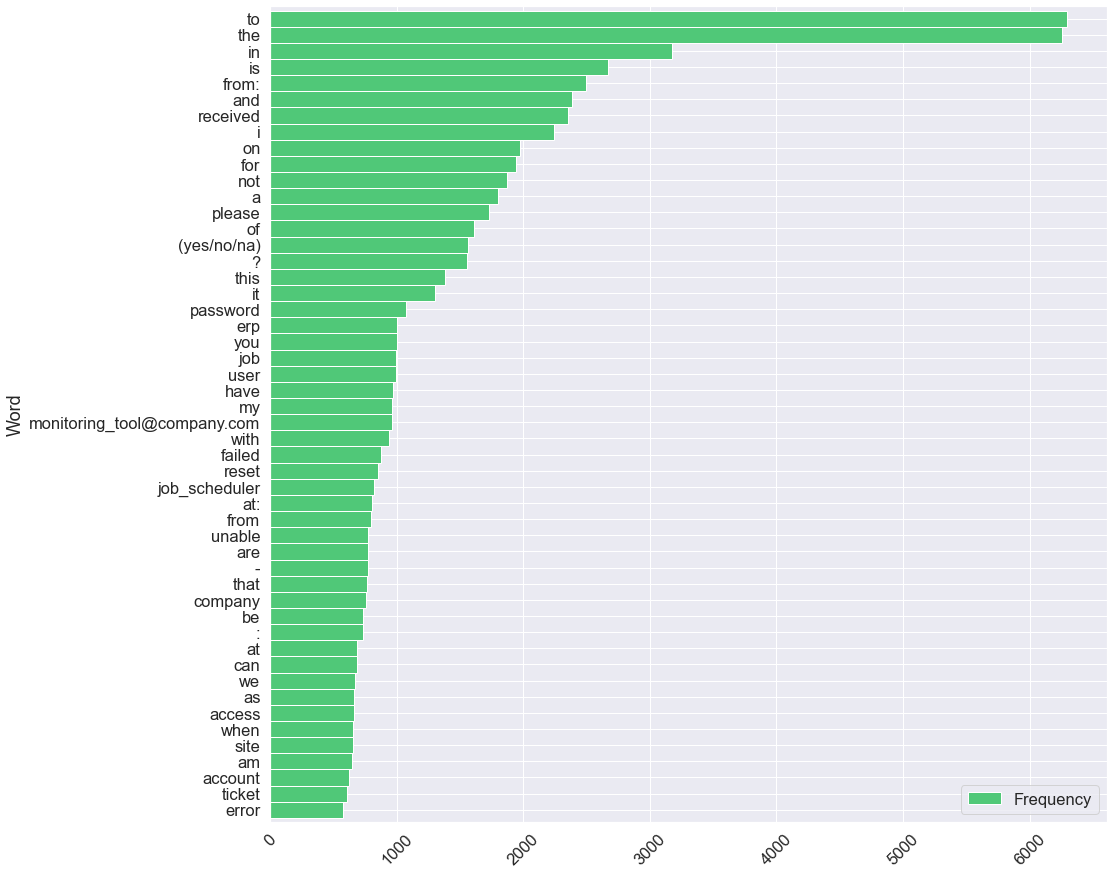

In [57]:
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [58]:
pprint(rslt.index.tolist(), compact=True)

['to', 'the', 'in', 'is', 'from:', 'and', 'received', 'i', 'on', 'for', 'not',
 'a', 'please', 'of', '(yes/no/na)', '?', 'this', 'it', 'password', 'erp',
 'you', 'job', 'user', 'have', 'my', 'monitoring_tool@company.com', 'with',
 'failed', 'reset', 'job_scheduler', 'at:', 'from', 'unable', 'are', '-',
 'that', 'company', 'be', ':', 'at', 'can', 'we', 'as', 'access', 'when',
 'site', 'am', 'account', 'ticket', 'error']


<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Stopwords and Anchor words like 'From:', 'Recieved' have to be stripped out
 </span></ul></h5>

In [59]:
# top 50 most frequent words in text
top_N = 50

words = (dataset.short_description.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [60]:
rslt[:50].transpose()

Word         to    in  not  job   on   is  password  erp  failed  \
Frequency  2167  1737  981  976  917  856       847  822     822   

Word       job_scheduler  ...  with    i   my  crm  ticket  windows    /   am  \
Frequency            811  ...   193  191  187  185     182      177  177  168   

Word       password_management_tool  network  
Frequency                       161      155  

[1 rows x 50 columns]

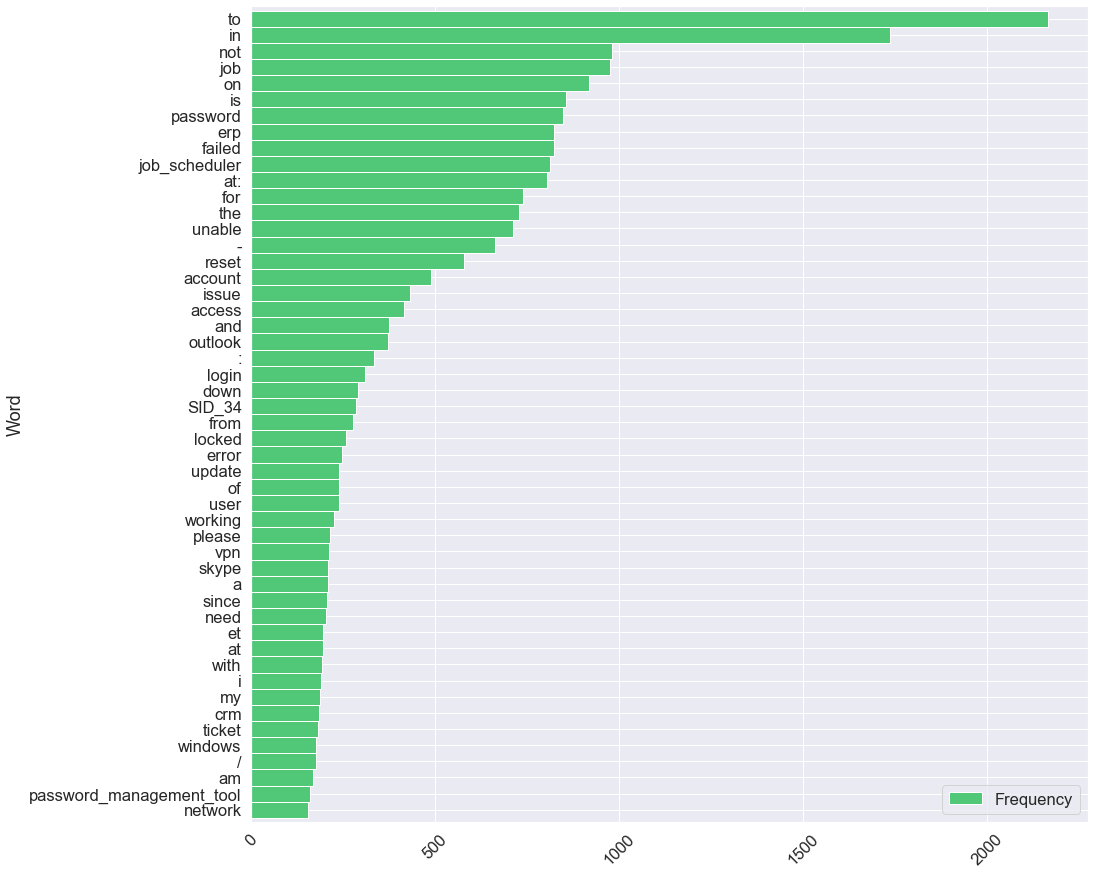

In [61]:
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [62]:
pprint(rslt.index.tolist(), compact=True)

['to', 'in', 'not', 'job', 'on', 'is', 'password', 'erp', 'failed',
 'job_scheduler', 'at:', 'for', 'the', 'unable', '-', 'reset', 'account',
 'issue', 'access', 'and', 'outlook', ':', 'login', 'down', 'SID_34', 'from',
 'locked', 'error', 'update', 'of', 'user', 'working', 'please', 'vpn', 'skype',
 'a', 'since', 'need', 'et', 'at', 'with', 'i', 'my', 'crm', 'ticket',
 'windows', '/', 'am', 'password_management_tool', 'network']


<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Many stopwords are occuring most frequently in the dataset. We might need to use stopword removal in our pre-processing if it improves the model performance.
 </span></ul></h5>

In [63]:
descr_string = ""
for description in dataset['description']:
    descr_string += description
    descr_string += " "

short_descr_string = ""
for description in dataset['short_description']:
    short_descr_string += description
    short_descr_string += " "

grp0_string = ""
for description in temp.loc[temp.group == 'Group 0', 'description']:
    grp0_string += description
    grp0_string += " "

other_string = ""
for description in temp.loc[temp.group == 'Other', 'description']:
    other_string += description
    other_string += " "

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Descriptions WordCloud</span></strong></li>
</ul></h4>

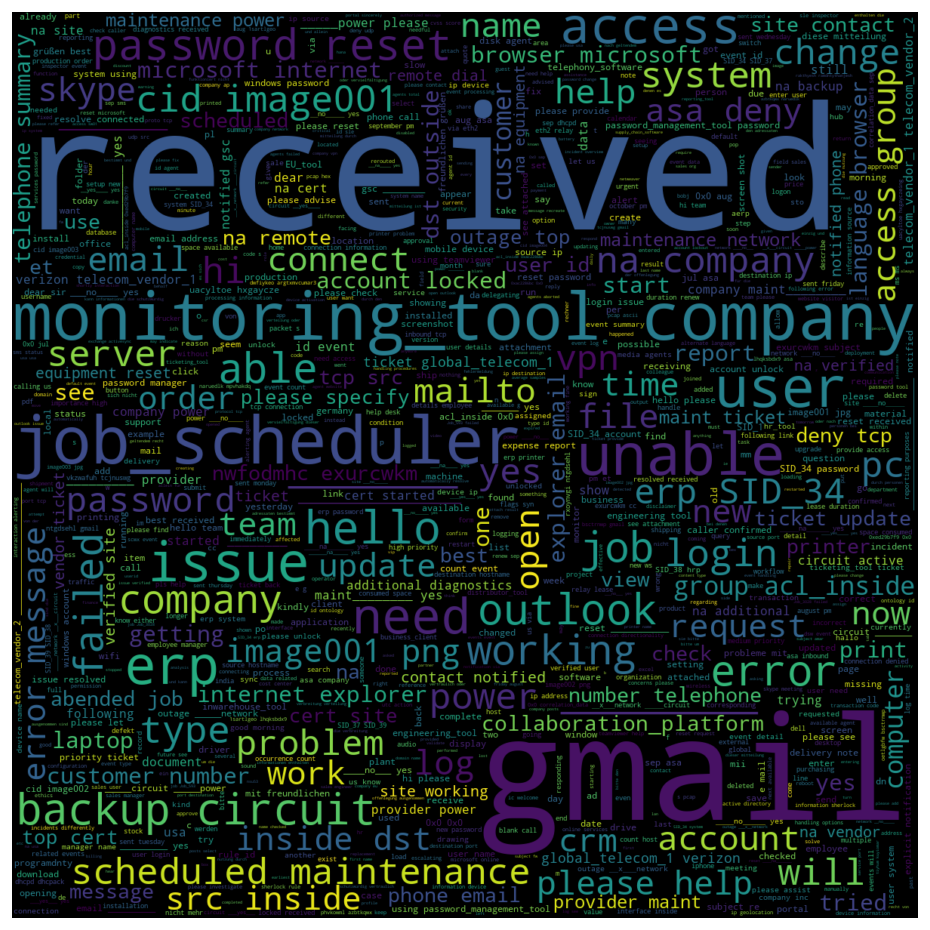

In [64]:
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(descr_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Short Descriptions WordCloud</span></strong></li>
</ul></h4>

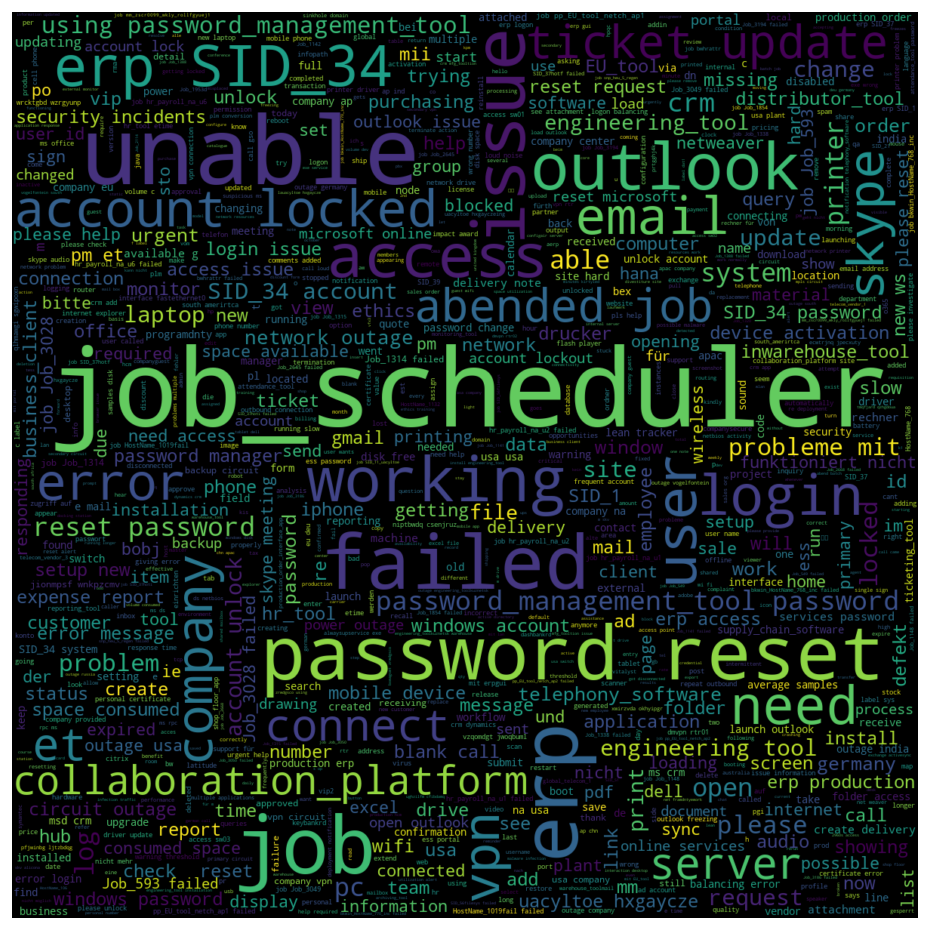

In [65]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(short_descr_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Group 0 Descriptions WordCloud</span></strong></li>
</ul></h4>

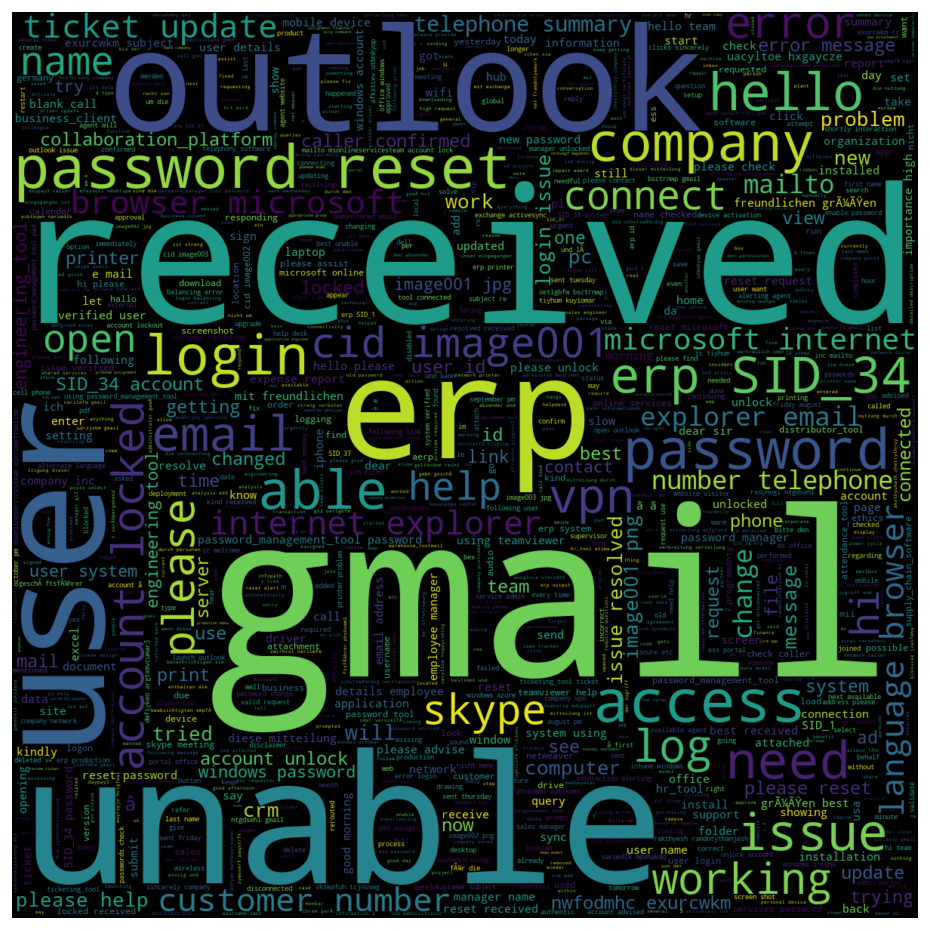

In [66]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(grp0_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Other Groups Descriptions WordCloud</span></strong></li>
</ul></h4>

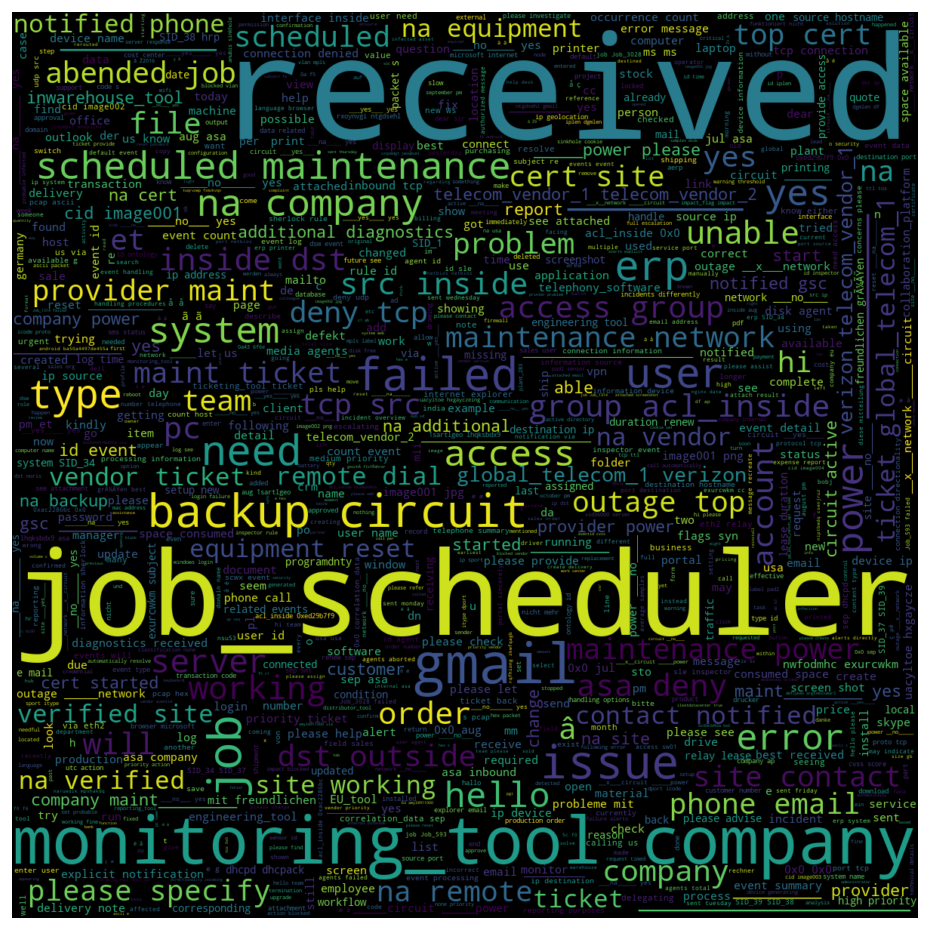

In [67]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(other_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Short Descriptions
 </span></ul></h4>

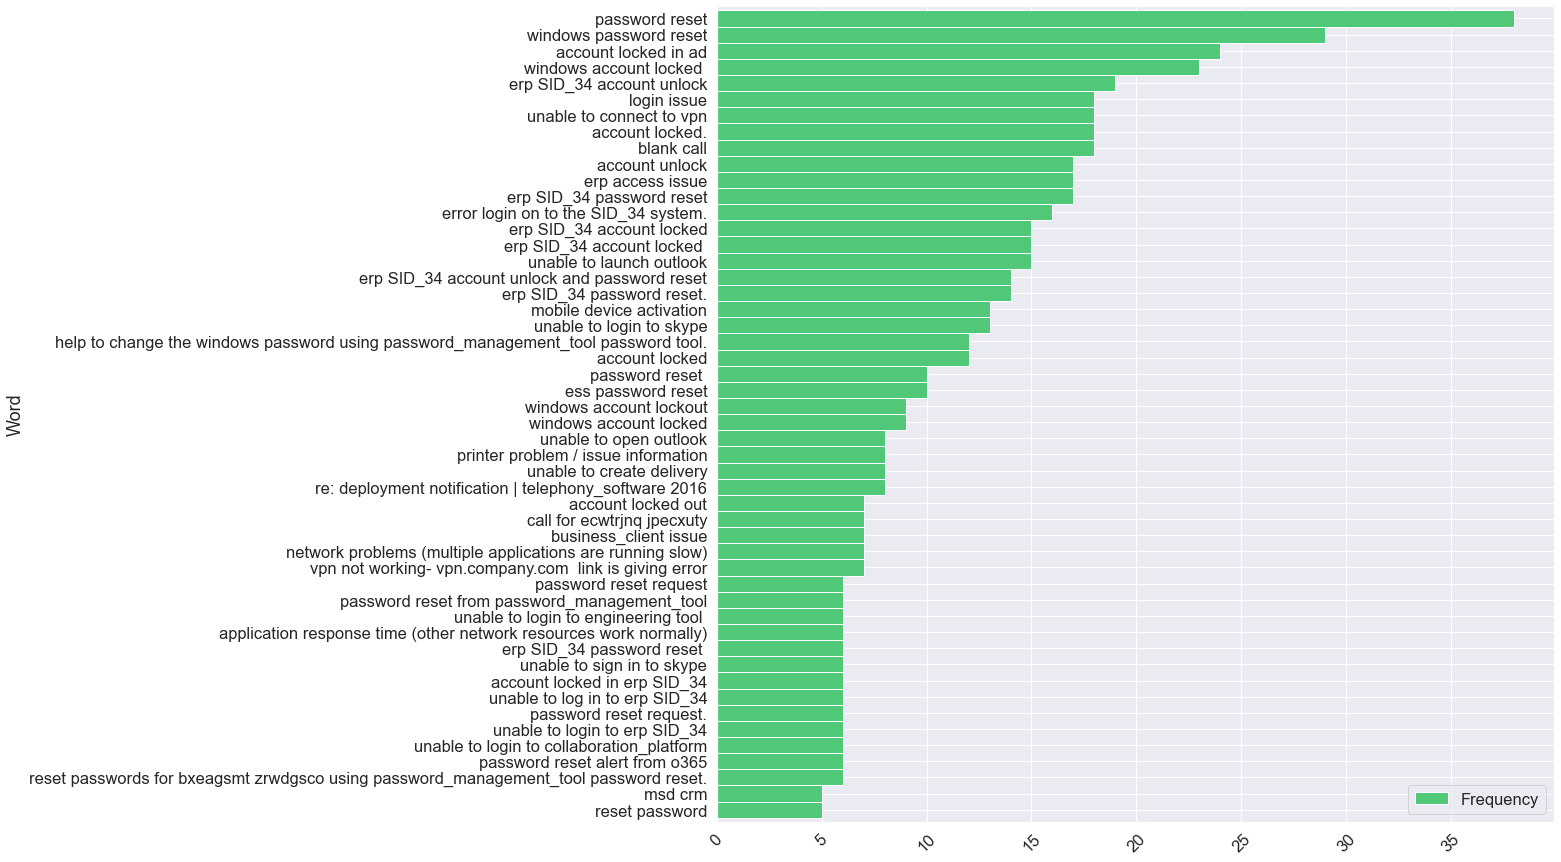

In [68]:
top_N = 50
rslt = pd.DataFrame(Counter(dataset.short_description.tolist()).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Descriptions
 </span></ul></h4>

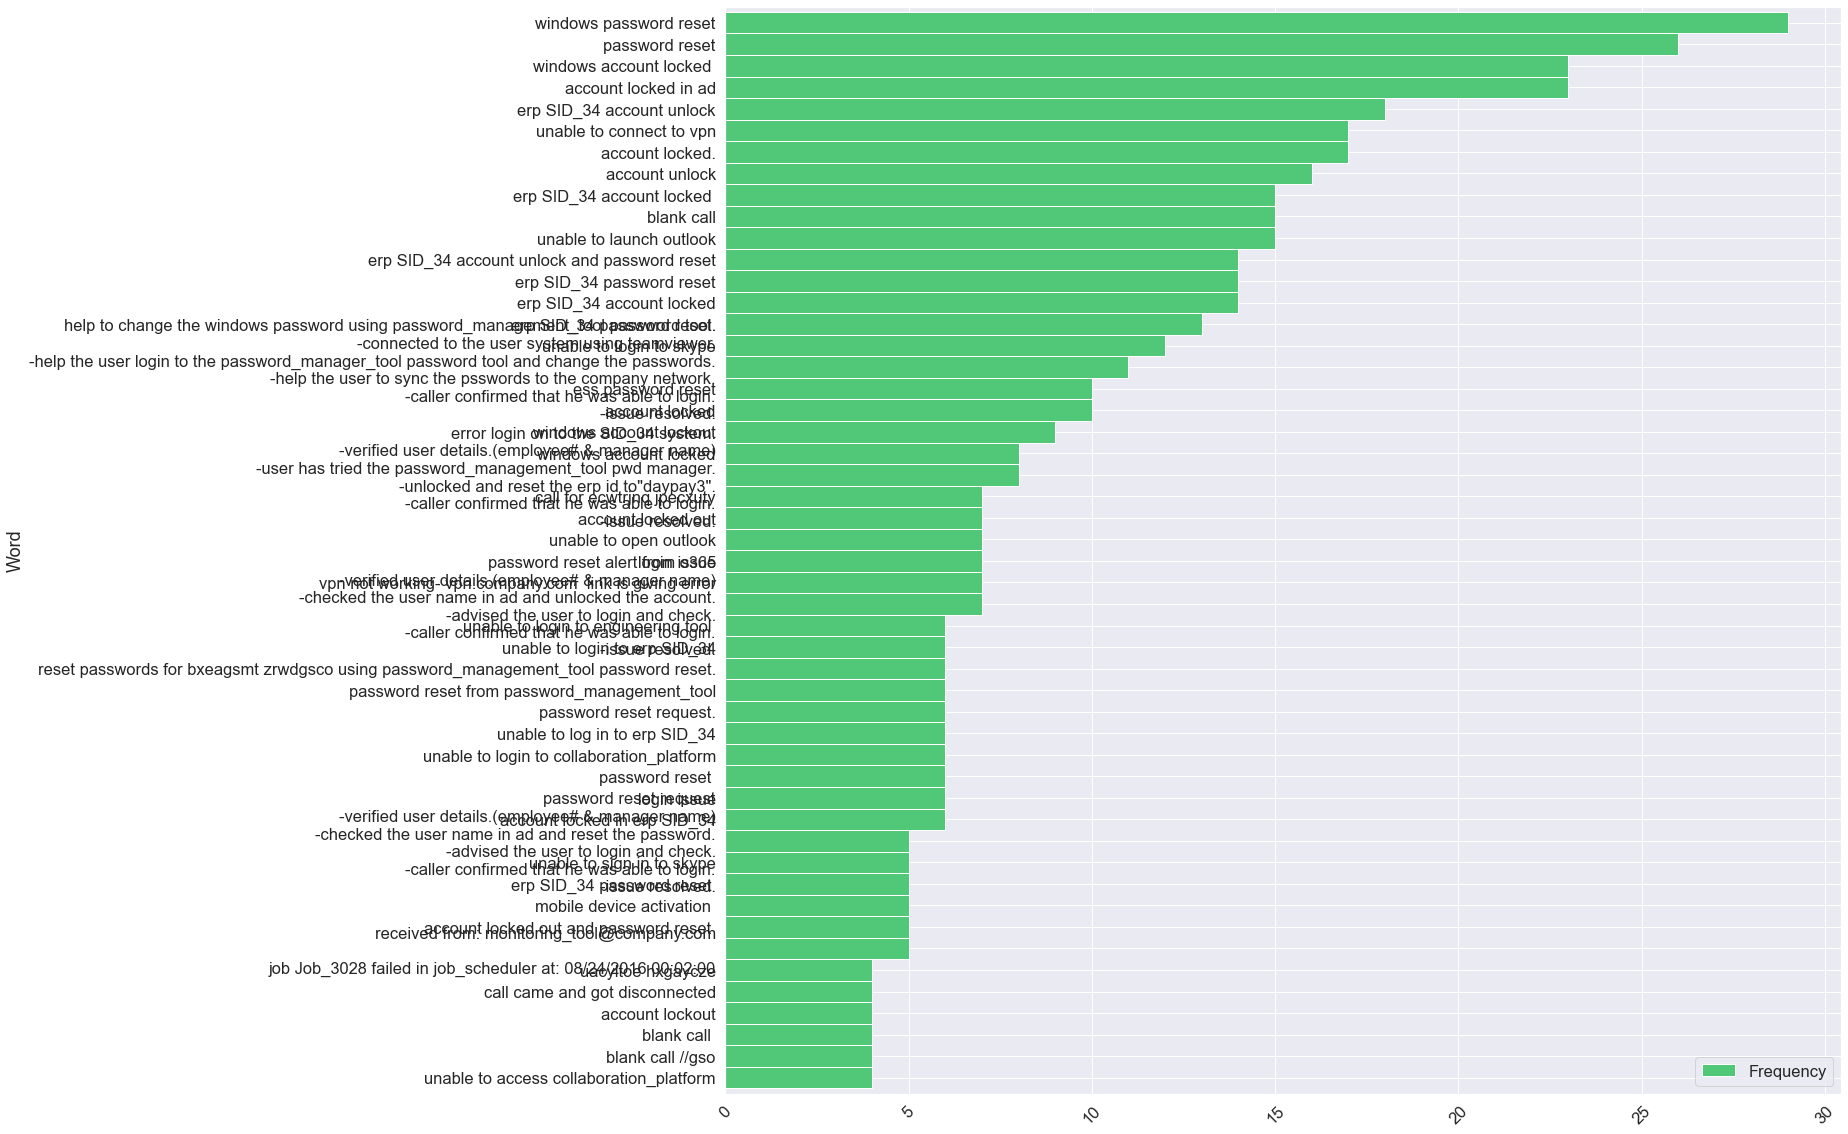

In [69]:
top_N = 50
rslt = pd.DataFrame(Counter(dataset.description.tolist()).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(20, 20), color='#50C878')
plt.xticks(rotation=45)
plt.show()

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Description Lengths vs. Functional Group</span></strong></li>
</ul></h3>

In [70]:
le = LabelEncoder()
dataset['group_code'] = le.fit_transform(dataset.group)
dataset.sample(7)

short_description  \
1895  erp password change with password_management_t...   
6097     apac china pbx/telephony_software system issue   
2054                               hr_tool etime issue    
5964  add im:mfg_planner_reference to the miiadmin e...   
6177            unable to install draftsight on the pc    
5308                            computer can't started    
4126  job Job_303 failed in job_scheduler at: 09/17/...   

                                            description             caller  \
1895  hi gso,\ni tried thrgxqsuojr xwbesorfs to rene...  vykbweum hpvctbse   
6097  apac china& dc have ip phone issue, one e1 lin...  bqdyhnoj rwyvsfgn   
2054                               hr_tool etime issue   zywoxerf paqxtrfk   
5964  add im:mfg_planner_reference to the miiadmin e...  dctvfjrn oypnxftq   
6177            unable to install draftsight on the pc   jgxclrzp jzeantui   
5308                           computer can't started    hctajofe qgrkcxyt   
4126  received from: monitoring_tool@company.com\n\n...  bpctwhsn kzqsbmtp   

       group  char_length  word_length  short_char_length  short_word_length  \
1895   GRP_0          330           45                109                 13   
6097  GRP_37          462           79                 46                  5   
2054   GRP_0           20            3                 20                  3   
5964   GRP_2          163           24                 70                 10   
6177   GRP_0           39            7                 39                  7   
5308  GRP_31           24            3                 23                  3   
4126   GRP_8          105           11                 61                  8   

                description_keywords    short_description_keywords  group_code  
1895  thrgxqsuojr xwbesorfs to renew           erp password change           0  
6097              received busy tone                apac china pbx          31  
2054                tool etime issue              tool etime issue           0  
5964                miiadmin erp SID              miiadmin erp SID          12  
6177    unable to install draftsight  unable to install draftsight           0  
5308         computer ca n't started       computer ca n't started          25  
4126                         job Job                       job Job          72

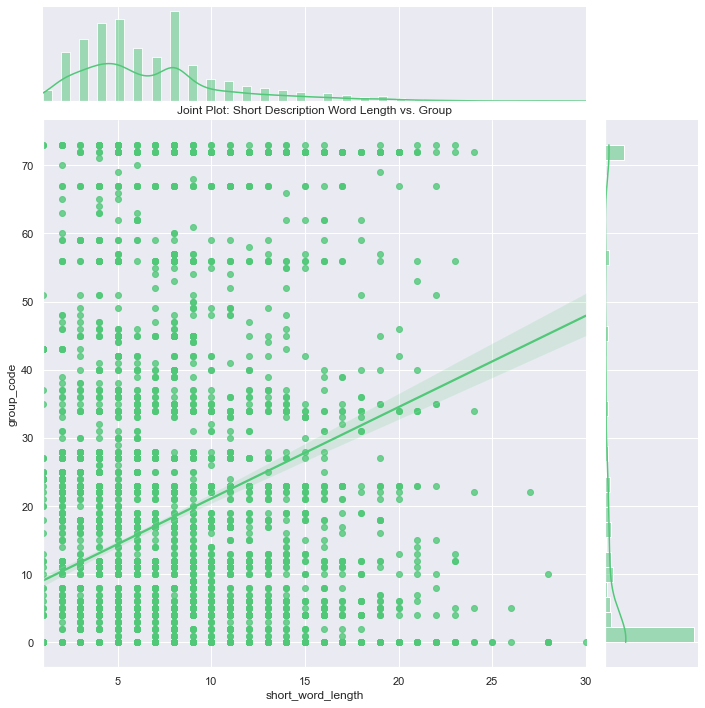

In [71]:
sns.set()
sns.jointplot(dataset.short_word_length, dataset.group_code, 
              kind='reg', color='#50C878', height=10)
plt.title('Joint Plot: Short Description Word Length vs. Group')
plt.show()

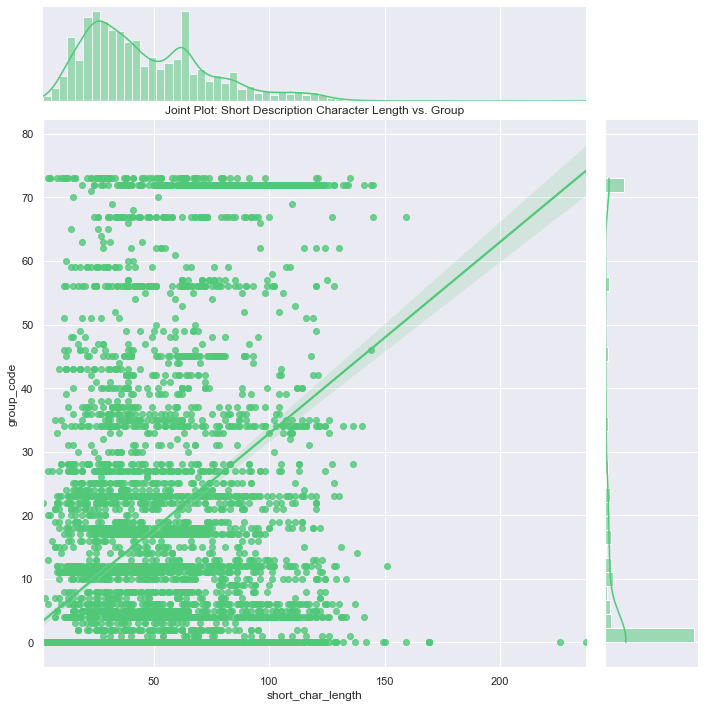

In [72]:
sns.set()
sns.jointplot(dataset.short_char_length, dataset.group_code, 
              kind='reg', color='#50C878', height=10)
plt.title('Joint Plot: Short Description Character Length vs. Group')
plt.show()

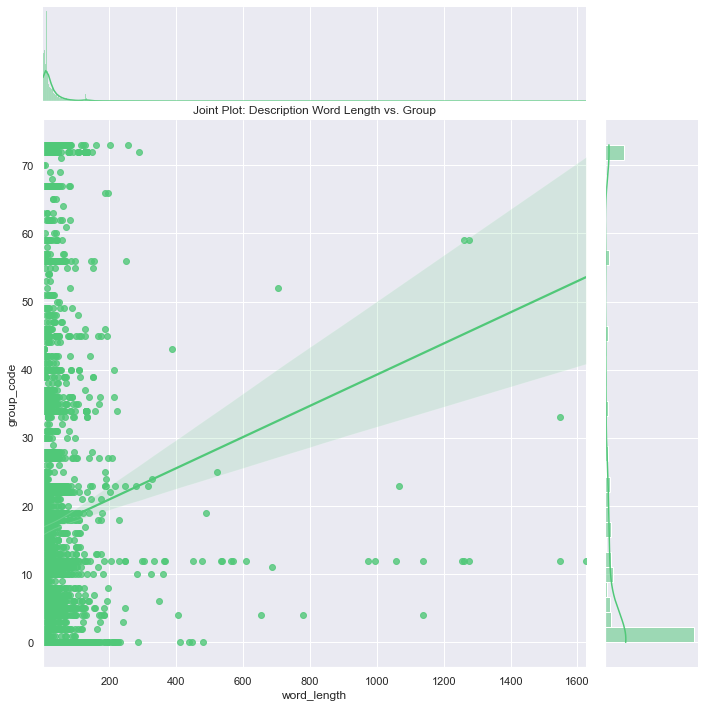

In [73]:
sns.set()
sns.jointplot(dataset.word_length, dataset.group_code, 
              kind='reg', color='#50C878', height=10)
plt.title('Joint Plot: Description Word Length vs. Group')
plt.show()

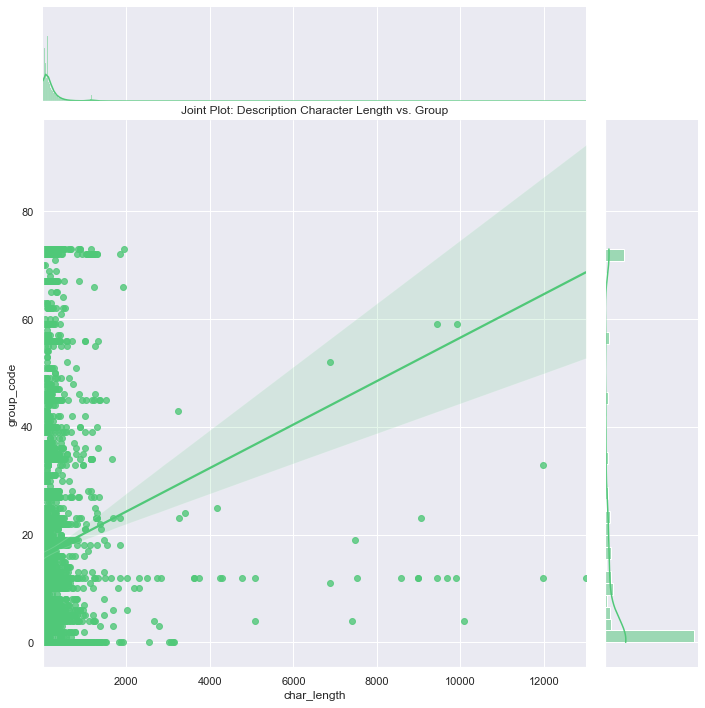

In [74]:
sns.set()
sns.jointplot(dataset.char_length, dataset.group_code, 
              kind='reg', color='#50C878', height=10)
plt.title('Joint Plot: Description Character Length vs. Group')
plt.show()

In [75]:
# binning the lengths

import jenkspy

NUM_BINS = 100
# calculates the natural breaks in a series, exploiting the Fisher-Jenks algorithm
# https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization
breaks = jenkspy.jenks_breaks(dataset['char_length'], nb_class=NUM_BINS)
labels = list(range(len(breaks) - 1))
pprint(breaks, compact=True)

[3.0, 17.0, 23.0, 28.0, 34.0, 40.0, 47.0, 55.0, 63.0, 71.0, 80.0, 90.0, 101.0,
 109.0, 117.0, 126.0, 137.0, 149.0, 160.0, 170.0, 180.0, 190.0, 201.0, 213.0,
 224.0, 235.0, 247.0, 259.0, 271.0, 283.0, 295.0, 308.0, 323.0, 338.0, 354.0,
 372.0, 392.0, 412.0, 431.0, 449.0, 468.0, 486.0, 508.0, 537.0, 568.0, 596.0,
 620.0, 653.0, 684.0, 720.0, 765.0, 801.0, 837.0, 866.0, 908.0, 934.0, 990.0,
 1026.0, 1063.0, 1116.0, 1157.0, 1176.0, 1197.0, 1234.0, 1265.0, 1301.0, 1347.0,
 1398.0, 1478.0, 1526.0, 1692.0, 1877.0, 1952.0, 2013.0, 2172.0, 2293.0, 2548.0,
 2744.0, 2833.0, 3062.0, 3141.0, 3249.0, 3403.0, 3628.0, 3734.0, 4169.0, 4286.0,
 4766.0, 5087.0, 6887.0, 7403.0, 7524.0, 8575.0, 8991.0, 9063.0, 9440.0, 9678.0,
 9912.0, 10077.0, 11968.0, 13001.0]


In [76]:
dataset['char_length_bins'] = pd.cut(dataset['char_length'] ,bins=breaks, labels=labels, include_lowest=True)

In [77]:
dataset

short_description  \
0                                           login issue   
1                                               outlook   
2                                    cant log in to vpn   
3                         unable to access hr_tool page   
4                                          skype error    
...                                                 ...   
8495                  emails not coming in from zz mail   
8496                           telephony_software issue   
8497  vip2: windows password reset for tifpdchb pedx...   
8498                       machine não está funcionando   
8499  an mehreren pc`s lassen sich verschiedene prgr...   

                                            description             caller  \
0     -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1     \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
2     \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
3                         unable to access hr_tool page  xbkucsvz gcpydteq   
4                                          skype error   owlgqjme qhcozdfx   
...                                                 ...                ...   
8495  \n\nreceived from: avglmrts.vhqmtiua@gmail.com...  avglmrts vhqmtiua   
8496                           telephony_software issue  rbozivdq gmlhrtvp   
8497  vip2: windows password reset for tifpdchb pedx...  oybwdsgx oxyhwrfz   
8498  i am unable to access the machine utilities to...  ufawcgob aowhxjky   
8499  an mehreren pc`s lassen sich verschiedene prgr...  kqvbrspl jyzoklfx   

       group  char_length  word_length  short_char_length  short_word_length  \
0      GRP_0          206           33                 11                  2   
1      GRP_0          194           25                  7                  1   
2      GRP_0           87           11                 18                  5   
3      GRP_0           29            5                 29                  5   
4      GRP_0           12            2                 12                  2   
...      ...          ...          ...                ...                ...   
8495  GRP_29          141           19                 33                  7   
8496   GRP_0           24            2                 24                  2   
8497   GRP_0           50            7                 50                  7   
8498  GRP_62          103           17                 30                  4   
8499  GRP_49           82           11                 70                  9   

                             description_keywords  \
0                          verified user details.   
1                appearing in my outlook calendar   
2                                   log on to vpn   
3                                       tool page   
4                                     skype error   
...                                           ...   
8495                               good afternoon   
8496                               software issue   
8497          windows password reset for tifpdchb   
8498      finish the drawers adjustment settings.   
8499  sich verschiedene prgramdntyme nicht öffnen   

                       short_description_keywords  group_code char_length_bins  
0                                     login issue           0               22  
1                                         outlook           0               21  
2                                   log in to vpn           0               10  
3                                       tool page           0                3  
4                                     skype error           0                0  
...                                           ...         ...              ...  
8495                            emails not coming          22               16  
8496                               software issue           0                2  
8497          windows password reset for tifpdchb           0    

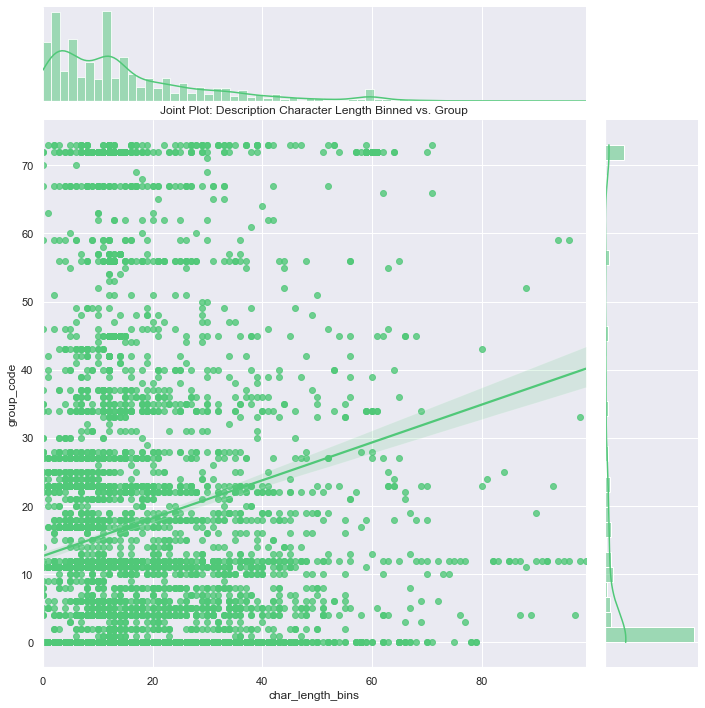

In [78]:
sns.set()
sns.jointplot(dataset.char_length_bins.astype(int), dataset.group_code, 
              kind='reg', color='#50C878', height=10)
plt.title('Joint Plot: Description Character Length Binned vs. Group')
plt.show()

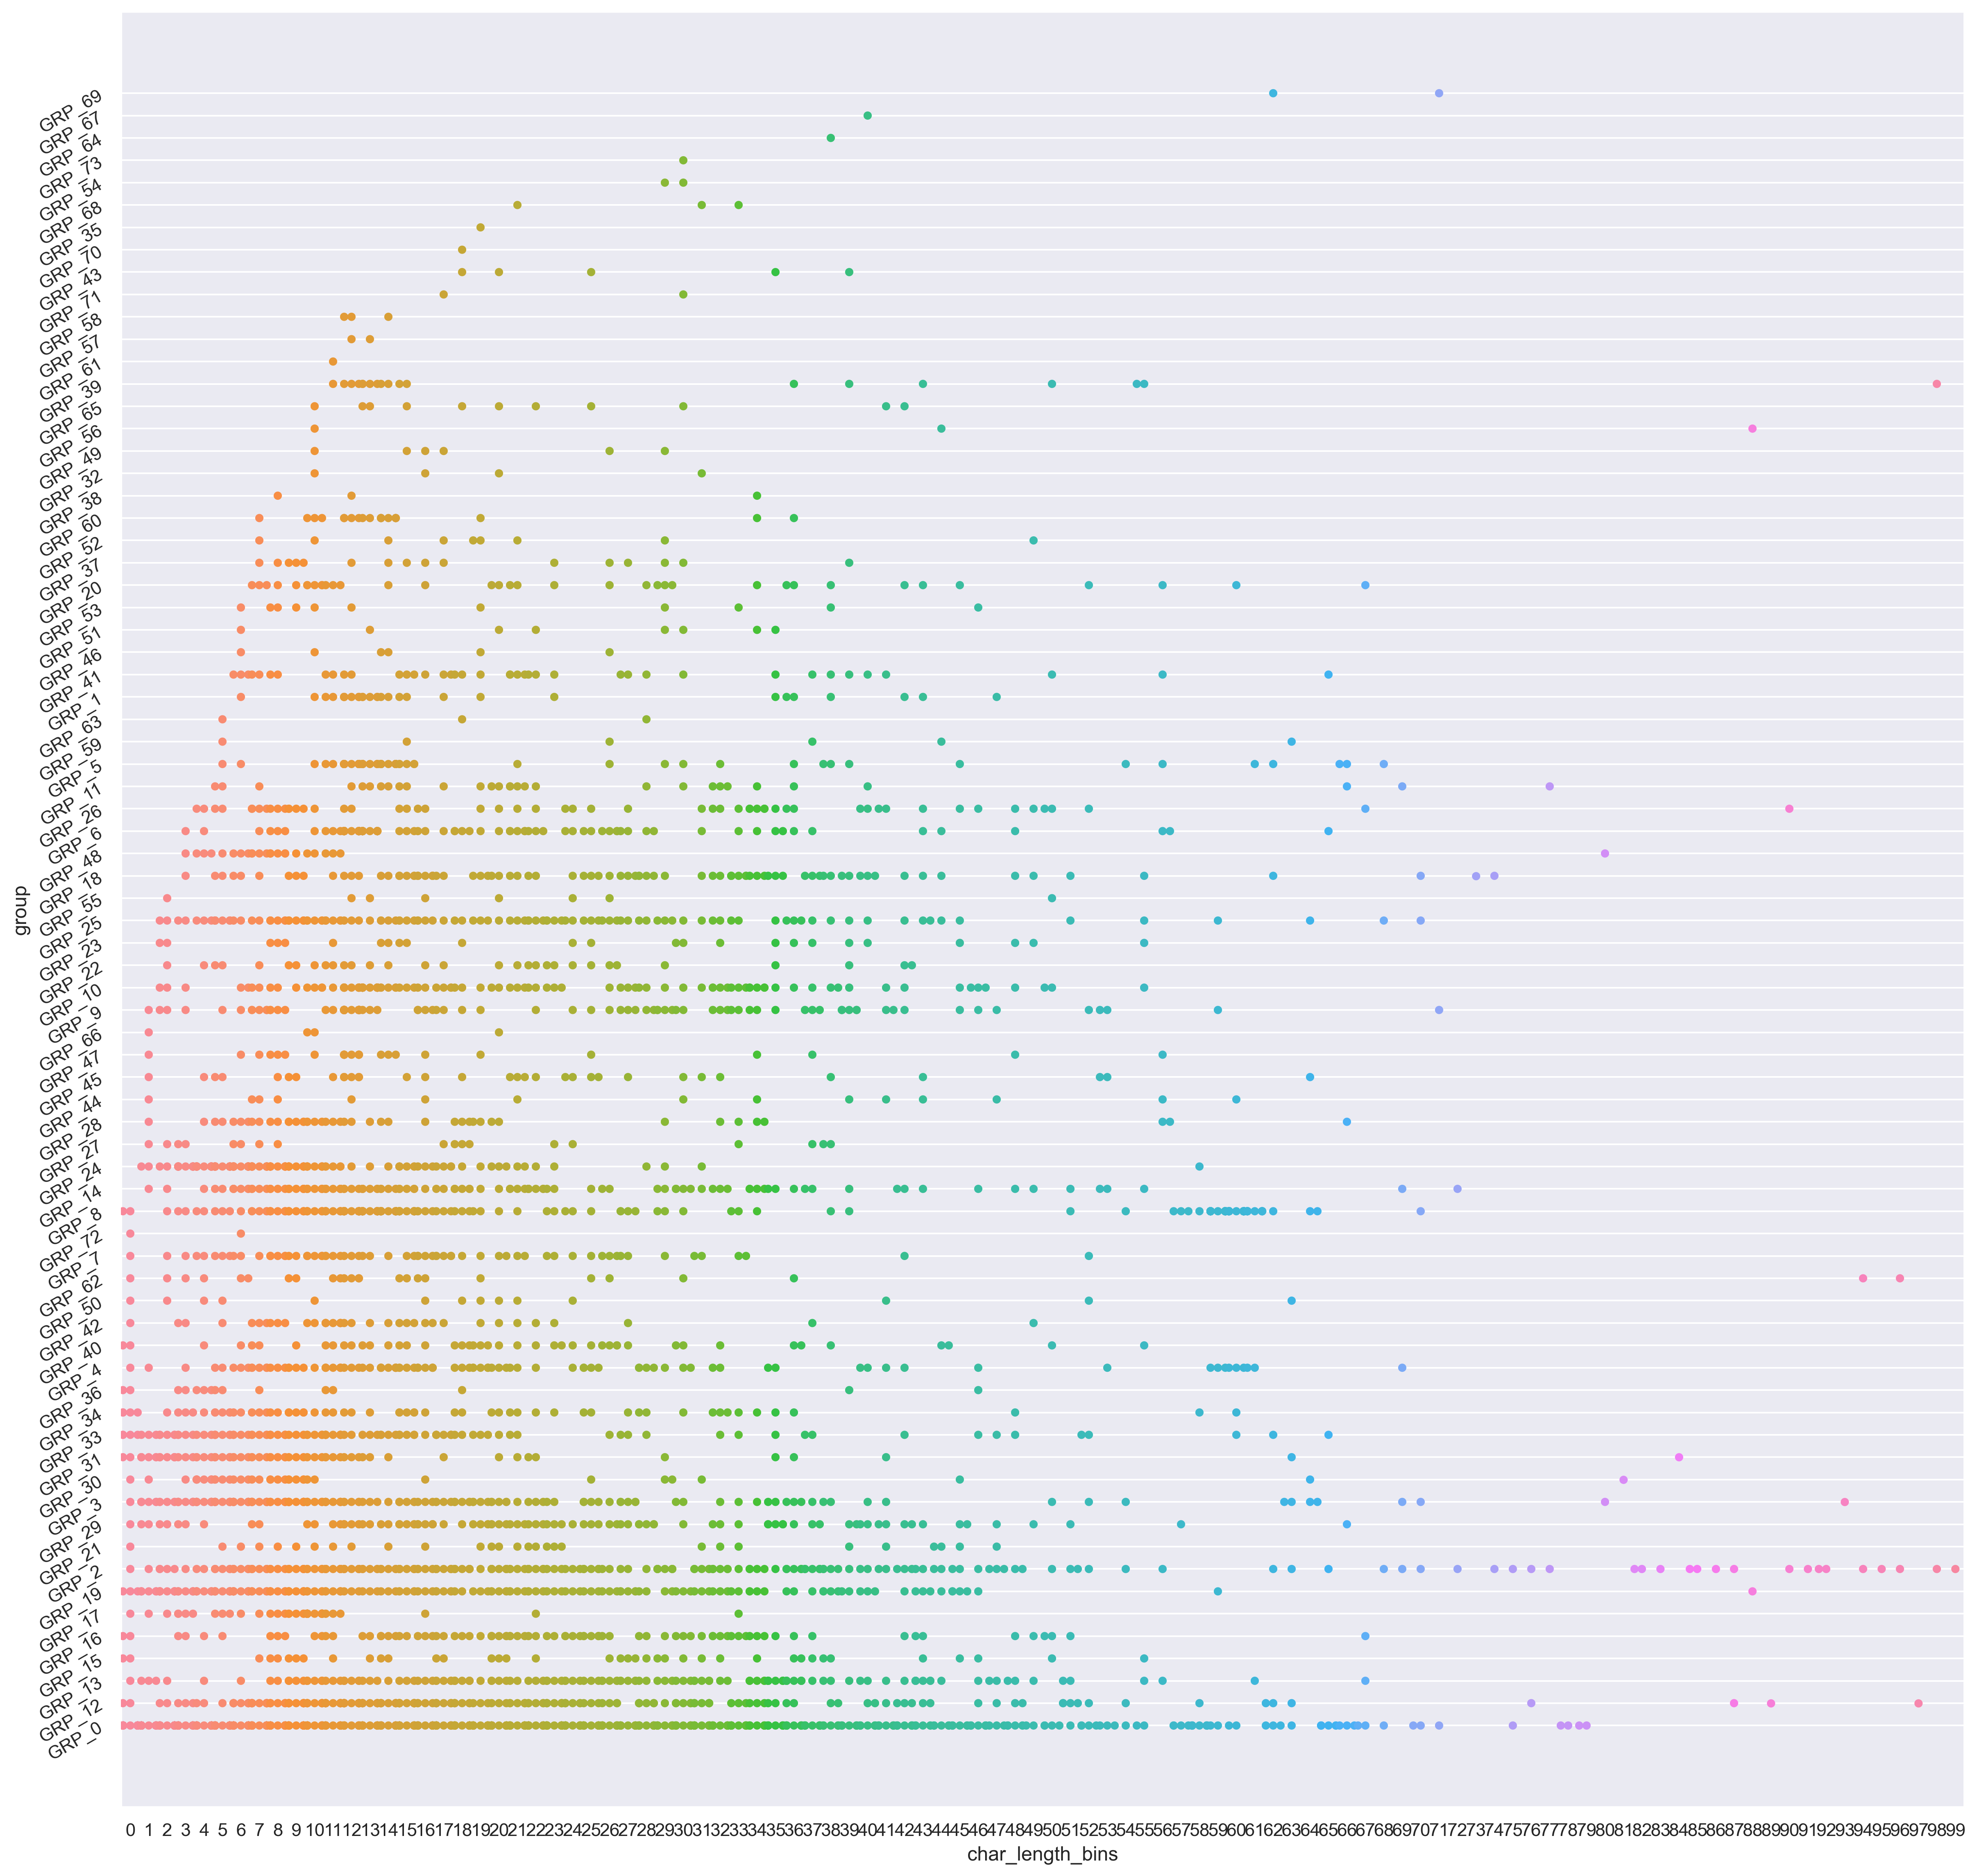

In [79]:
sns.set()
plt.figure(figsize=(20,20), dpi=300)
sns.swarmplot(x="char_length_bins", y="group", data=dataset)
plt.yticks(rotation=30)
plt.show()

In [80]:
# TODO: perform Chi2 Test with group to decide whether to include length features
import scipy.stats as stats
data_crosstab = pd.crosstab(dataset['caller'],
                            dataset['group'],
                            margins=True,
                            margins_name="Total")
data_crosstab

group              GRP_0  GRP_1  GRP_10  GRP_11  GRP_12  GRP_13  GRP_14  \
caller                                                                    
DEsowkrH sciejzNE      0      0       0       0       0       1       0   
HdOuWxAt qfKdlJMx      1      0       0       0       0       0       0   
ZkBogxib QsEJzdZO      0      1       2       0       0       0       2   
abiuclvj brziktno      0      0       0       0       0       0       0   
abtknpew ifcekjdb      1      0       0       0       0       0       0   
...                  ...    ...     ...     ...     ...     ...     ...   
zylwdbig wdkbztjp      1      0       0       0       0       0       0   
zymdwqsi jzvbthil      1      0       0       0       0       0       0   
zywoxerf paqxtrfk      9      0       0       0       0       0       0   
zyxjagro vjgozhpn      2      0       0       0       0       0       0   
Total               3975     31     140      30     257     145     118   

group              GRP_15  GRP_16  GRP_17  ...  GRP_68  GRP_69  GRP_7  GRP_70  \
caller                                     ...                                  
DEsowkrH sciejzNE       0       0       0  ...       0       0      0       0   
HdOuWxAt qfKdlJMx       0       0       0  ...       0       0      0       0   
ZkBogxib QsEJzdZO       0       0       0  ...       0       0      0       0   
abiuclvj brziktno       0       0       0  ...       0       0      0       0   
abtknpew ifcekjdb       0       0       0  ...       0       0      0       0   
...                   ...     ...     ...  ...     ...     ...    ...     ...   
zylwdbig wdkbztjp       0       0       0  ...       0       0      0       0   
zymdwqsi jzvbthil       0       0       0  ...       0       0      0       0   
zywoxerf paqxtrfk       0       0       0  ...       0       0      0       0   
zyxjagro vjgozhpn       0       0       0  ...       0       0      0       0   
Total                  39      85      81  ...       3       2     68       1   

group              GRP_71  GRP_72  GRP_73  GRP_8  GRP_9  Total  
caller                                                          
DEsowkrH sciejzNE       0       0       0      0      0      2  
HdOuWxAt qfKdlJMx       0       0       0      0      0      1  
ZkBogxib QsEJzdZO       0       0       0     54     31    151  
abiuclvj brziktno       0       0       0      0      0      1  
abtknpew ifcekjdb       0       0       0      0      0      1  
...                   ...     ...     ...    ...    ...    ...  
zylwdbig wdkbztjp       0       0       0      0      0      1  
zymdwqsi jzvbthil       0       0       0      0      0      1  
zywoxerf paqxtrfk       0       0       0      0      0      9  
zyxjagro vjgozhpn       0       0       0      0      0      2  
Total                   2       2       1    661    252   8499  

[2951 rows x 75 columns]

In [81]:
# significance level
alpha = 0.05

# Calcualtion of Chisquare test statistics
chi_square = 0
rows = dataset['caller'].unique()
columns = dataset ['group'].unique()
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 268747.2241233948  and p value is: 0.0
Null Hypothesis is rejected.


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Language Detection</span></strong></li>
</ul></h3>

https://fasttext.cc/docs/en/language-identification.html

In [82]:
# TODO: try out fastText pre-trained language identification model (less latency) &
# Google CLD3 (Google Compact Language Detector v3)

# ! pip -q install fasttext
# import fasttext

# path_to_pretrained_model = './artifact/models/lid.176.bin'  # lid (Language identification modeel which can recognize 176 languages)
# fmodel = fasttext.load_model(path_to_pretrained_model)
# text = "+86 Hi there"
# fmodel.predict([text])

In [83]:
from langdetect import DetectorFactory, detect_langs
from langdetect.lang_detect_exception import LangDetectException

DetectorFactory.seed = seed

# detect the languages in the dataset
languages = []
errs = []
lang_samples = defaultdict(list)
for text in tqdm(dataset.description):
    try:
        lang = detect_langs(text)
        clean_lang = str(lang).split(':')[0][1:]
        lang_samples[clean_lang].append(text)
        languages.append(clean_lang)
    except LangDetectException as e:
        errs.append(text)
        print('text: ', text)
        print(e)

 74%|███████████████████████████████████████████████████████▎                   | 6269/8499 [01:24<00:25, 87.95it/s]

text:  +86  
No features in text.


100%|███████████████████████████████████████████████████████████████████████████| 8499/8499 [01:54<00:00, 74.18it/s]


In [84]:
print("Unique languages in the descriptions: "
      f"{np.unique(languages)}")

Unique languages in the descriptions: ['af' 'ca' 'cs' 'cy' 'da' 'de' 'en' 'es' 'et' 'fi' 'fr' 'hr' 'hu' 'id'
 'it' 'ja' 'ko' 'lt' 'lv' 'nl' 'no' 'pl' 'pt' 'ro' 'sk' 'sl' 'so' 'sq'
 'sv' 'sw' 'tl' 'tr' 'vi' 'zh-cn']


In [85]:
lang_freqs = {i: len(lang_samples[i]) for i in lang_samples}
freq_df = pd.DataFrame({'Language': lang_freqs.keys(), 'Frequency': lang_freqs.values()},
                      columns=['Language', 'Frequency']).set_index('Language')
freq_df.T

Language     en  no  es   it   af  sv  ca  nl   de   fr  ...  lt  ja  sk  tr  \
Frequency  7058  67  65  144  262  37  40  48  424  111  ...   4   1   1   1   

Language   sw  vi  so  lv  cs  hu  
Frequency   1   3   1   2   1   1  

[1 rows x 34 columns]

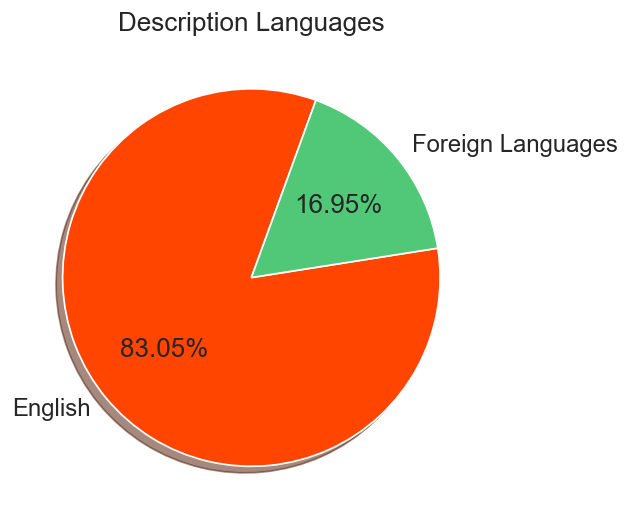

In [86]:
sns.set(font_scale=1.25)  # scale up font size

plt.figure(figsize=(5, 5), dpi=125)
eng = freq_df.loc['en'].tolist()[0]
foreign_lang = len(dataset) - freq_df.loc['en'].tolist()[0]

plt.pie(x=[eng, foreign_lang],
        explode=(0, 0),
        labels=['English', 'Foreign Languages'],
        autopct='%1.2f%%',
        shadow=True,
        startangle=70,
        colors=['#FF4500', '#50C878'])

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.title('Description Languages')
plt.show()

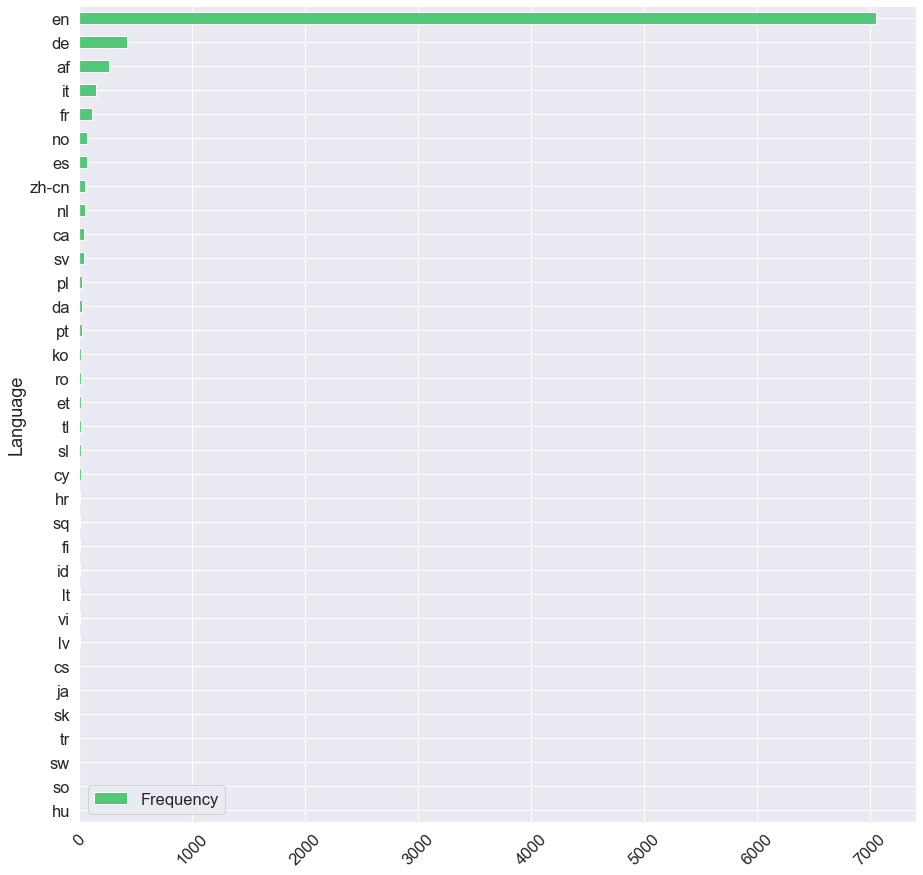

In [87]:
sns.set(font_scale=1.5)  # scale up font size
freq_df.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=0.5, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [88]:
# for i in lang_samples:
#     print(i)
#     try:
#         print(random.sample(lang_samples[i], 3))
#     except Exception:
#         print(random.sample(lang_samples[i], 1))
#     print('')

In [89]:
# detect the languages in the dataset
languages = []
lang_samples = defaultdict(list)
for text in tqdm(dataset.short_description):
    try:
        lang = detect_langs(text)
        clean_lang = str(lang).split(':')[0][1:]
        lang_samples[clean_lang].append(text)
        languages.append(clean_lang)
    except LangDetectException as e:
        errs.append(text)
        print('text: ', text)
        print(e)

 22%|████████████████▏                                                          | 1838/8499 [00:32<01:50, 60.27it/s]

text:  bgflmyar.xgufkidq@gmail.com
No features in text.


 35%|██████████████████████████▎                                                | 2986/8499 [00:51<01:30, 60.87it/s]

text:  ???????????????????
No features in text.


100%|███████████████████████████████████████████████████████████████████████████| 8499/8499 [02:29<00:00, 56.76it/s]


In [90]:
print("Unique languages in the short descriptions: "
      f"{np.unique(languages)}")

Unique languages in the short descriptions: ['af' 'ca' 'cs' 'cy' 'da' 'de' 'en' 'es' 'et' 'fi' 'fr' 'hr' 'hu' 'id'
 'it' 'ko' 'lt' 'lv' 'nl' 'no' 'pl' 'pt' 'ro' 'sk' 'sl' 'so' 'sq' 'sv'
 'sw' 'tl' 'tr' 'vi' 'zh-cn']


In [91]:
lang_freqs = {i: len(lang_samples[i]) for i in lang_samples}
freq_df = pd.DataFrame({'Language': lang_freqs.keys(), 'Frequency': lang_freqs.values()},
                       columns=['Language', 'Frequency']).set_index('Language')
freq_df.T

Language     en  et   no  es   it   nl   af  sv  ro   fr  ...  vi  hr  pt  ko  \
Frequency  6121  25  157  95  287  140  489  60  45  245  ...   9   6  33  15   

Language   lt  so  sw  lv  tr  hu  
Frequency   9   5   1   4   1   1  

[1 rows x 33 columns]

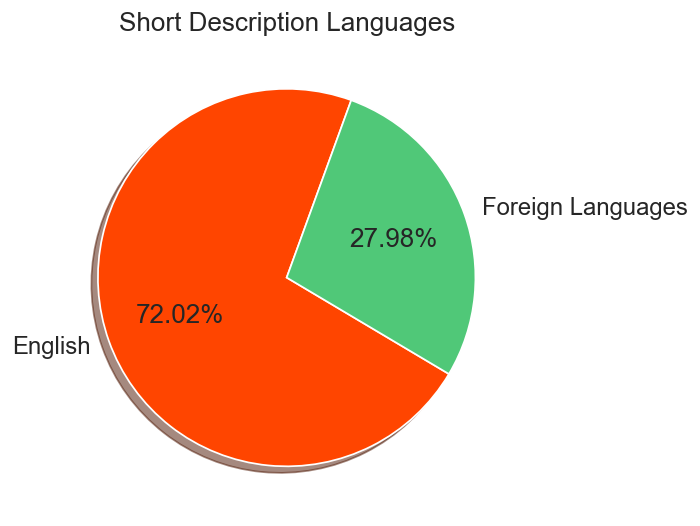

In [92]:
sns.set(font_scale=1.25)  # scale up font size

plt.figure(figsize=(5, 5), dpi=125)
eng = freq_df.loc['en'].tolist()[0]
foreign_lang = len(dataset) - freq_df.loc['en'].tolist()[0]

plt.pie(x=[eng, foreign_lang],
        explode=(0, 0),
        labels=['English', 'Foreign Languages'],
        autopct='%1.2f%%',
        shadow=True,
        startangle=70,
        colors=['#FF4500', '#50C878'])

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.title('Short Description Languages')
plt.show()

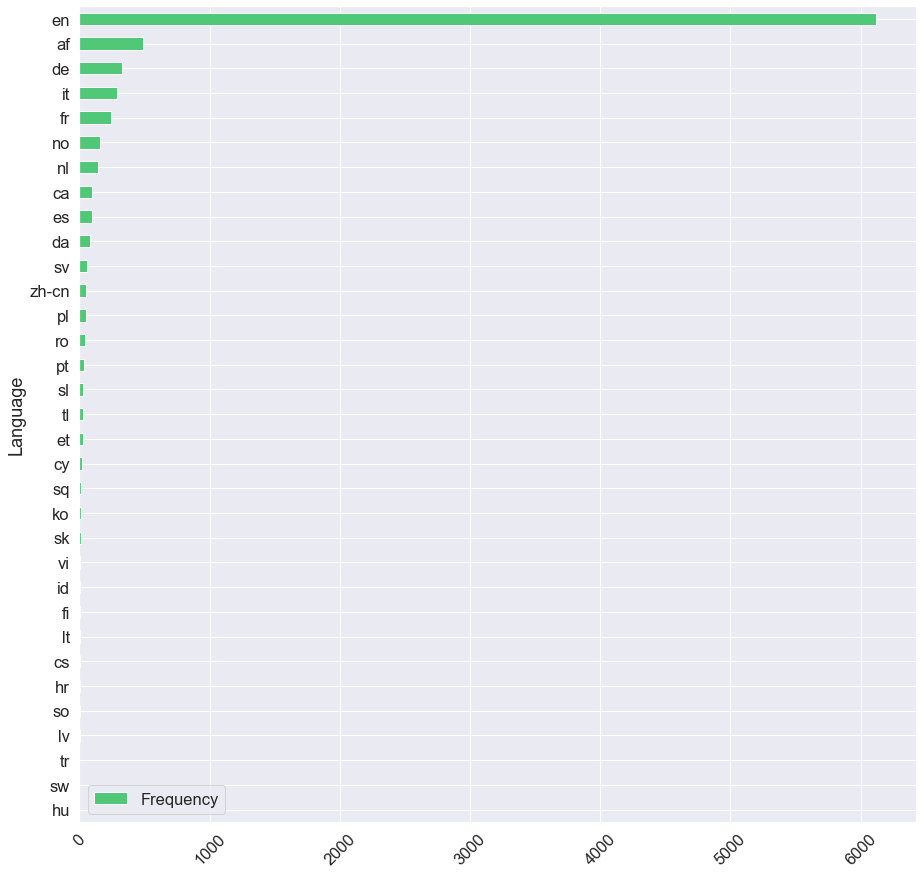

In [93]:
sns.set(font_scale=1.5)  # scale up font size
freq_df.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=0.5, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [94]:
# for i in lang_samples:
#     print(i)
#     try:
#         print(random.sample(lang_samples[i], 3))
#     except Exception:
#         print(random.sample(lang_samples[i], 1))
#     print('')

In [95]:
errs  # few errors where lang_detect failed, need to impute these irrelevant values

['+86  ', 'bgflmyar.xgufkidq@gmail.com', '???????????????????']

In [96]:
dataset[dataset.description == errs[0]]

short_description description  \
6253  in the inbox always show there are several ema...       +86     

                 caller  group  char_length  word_length  short_char_length  \
6253  mqbxwpfn uclrqfxa  GRP_0            5            1                 94   

      short_word_length description_keywords short_description_keywords  \
6253                 19                               inbox always show   

      group_code char_length_bins  
6253           0                0

In [97]:
dataset.loc[dataset.description == errs[0], 'description'] = dataset[dataset.description == errs[0]].short_description

In [98]:
dataset[dataset.short_description == errs[1]]

short_description  \
1836  bgflmyar.xgufkidq@gmail.com   

                                            description             caller  \
1836  bgflmyar.xgufkidq@gmail.com wanted to check if...  olckhmvx pcqobjnd   

      group  char_length  word_length  short_char_length  short_word_length  \
1836  GRP_0           83           13                 27                  1   

     description_keywords short_description_keywords  group_code  \
1836    tool on his phone                                      0   

     char_length_bins  
1836               10

In [99]:
dataset.loc[dataset.short_description == errs[1], 'short_description'] = dataset[dataset.short_description == errs[1]].description

In [100]:
dataset[dataset.short_description == errs[2]]

short_description                                        description  \
2975  ???????????????????  \n\nreceived from: yzbjhmpw.vzrulkog@gmail.com...   

                 caller  group  char_length  word_length  short_char_length  \
2975  yzbjhmpw vzrulkog  GRP_0         1207          131                 19   

      short_word_length                          description_keywords  \
2975                  1  company shared services gmbh geschäftsführer   

     short_description_keywords  group_code char_length_bins  
2975                                      0               62

In [101]:
dataset.loc[dataset.short_description == errs[2], 'short_description'] = dataset[dataset.short_description == errs[2]].description

In [102]:
def clean_incosistencies():
    dataset.loc[dataset.description == errs[0], 'description'] = dataset[dataset.description == errs[0]].short_description
    dataset.loc[dataset.short_description == errs[1], 'short_description'] = dataset[dataset.short_description == errs[1]].description
    dataset.loc[dataset.short_description == errs[2], 'short_description'] = dataset[dataset.short_description == errs[2]].description

# clean_incosistencies()

<h2><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Pre-Processing</span></strong></li>
</ul></h2>

In [103]:
dataset

short_description  \
0                                           login issue   
1                                               outlook   
2                                    cant log in to vpn   
3                         unable to access hr_tool page   
4                                          skype error    
...                                                 ...   
8495                  emails not coming in from zz mail   
8496                           telephony_software issue   
8497  vip2: windows password reset for tifpdchb pedx...   
8498                       machine não está funcionando   
8499  an mehreren pc`s lassen sich verschiedene prgr...   

                                            description             caller  \
0     -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1     \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
2     \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
3                         unable to access hr_tool page  xbkucsvz gcpydteq   
4                                          skype error   owlgqjme qhcozdfx   
...                                                 ...                ...   
8495  \n\nreceived from: avglmrts.vhqmtiua@gmail.com...  avglmrts vhqmtiua   
8496                           telephony_software issue  rbozivdq gmlhrtvp   
8497  vip2: windows password reset for tifpdchb pedx...  oybwdsgx oxyhwrfz   
8498  i am unable to access the machine utilities to...  ufawcgob aowhxjky   
8499  an mehreren pc`s lassen sich verschiedene prgr...  kqvbrspl jyzoklfx   

       group  char_length  word_length  short_char_length  short_word_length  \
0      GRP_0          206           33                 11                  2   
1      GRP_0          194           25                  7                  1   
2      GRP_0           87           11                 18                  5   
3      GRP_0           29            5                 29                  5   
4      GRP_0           12            2                 12                  2   
...      ...          ...          ...                ...                ...   
8495  GRP_29          141           19                 33                  7   
8496   GRP_0           24            2                 24                  2   
8497   GRP_0           50            7                 50                  7   
8498  GRP_62          103           17                 30                  4   
8499  GRP_49           82           11                 70                  9   

                             description_keywords  \
0                          verified user details.   
1                appearing in my outlook calendar   
2                                   log on to vpn   
3                                       tool page   
4                                     skype error   
...                                           ...   
8495                               good afternoon   
8496                               software issue   
8497          windows password reset for tifpdchb   
8498      finish the drawers adjustment settings.   
8499  sich verschiedene prgramdntyme nicht öffnen   

                       short_description_keywords  group_code char_length_bins  
0                                     login issue           0               22  
1                                         outlook           0               21  
2                                   log in to vpn           0               10  
3                                       tool page           0                3  
4                                     skype error           0                0  
...                                           ...         ...              ...  
8495                            emails not coming          22               16  
8496                               software issue           0                2  
8497          windows password reset for tifpdchb           0    

### Pipeline
* fix text encoding usng ftfy.fix_text
* handle other languages (drop or translate) (TODO)
* parse email messages to retain only subject and body
* clean up emails, links, website links, telephone numbers
* clean up anchor words like: 'Received from:', 'name:', 'hello', 'hello team' , 'cid' ...
* clean up security logs (TODO)
* clean up outage questionnaires (TODO)
* clean html tags if they exist
* clean /r /n characters
* strip caller names in descriptions
* translate accented characters (á -> a)
* convert unicode characters to ascii
* expand contractions (they're -> they are)
* clean stopwords & any custom stopwords
* clean up extra whitespaces & tokenize
* remove gibberish (after language translation)
* strip extra punctuation
* lemmatization/stemming (if needed for a model)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">TODO: Language Translation</span></strong></li>
</ul></h3>

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">TODO: Outage Questionnaires</span></strong></li>
</ul></h3>

In [104]:
outage_df = dataset.reset_index().loc[pd.Series(['outage' in i for i in  dataset.description.tolist()])]

In [105]:
outage_df.group.value_counts()

GRP_8     139
GRP_4      16
GRP_0       8
GRP_16      1
Name: group, dtype: int64

In [106]:
outage_df

index                                  short_description  \
78       78  power outage:UK al, 1st and 5th ave sites hard...   
79       79  power outage : germany, mx: site is hard down ...   
189     189  network outage: india: site hard down since at...   
215     215  network outage  - warehouse: node company-ups-...   
240     240  power outage :australia australia: site hard d...   
...     ...                                                ...   
8097   8098  network outage, russia ru, company-russia-vpn-...   
8184   8185  circuit outage: vogelfontein, south africa mpl...   
8272   8273  network outage : south amerirtca(argentina) si...   
8274   8275  network outage: usa site is hard down since 05...   
8315   8316  network outage: sao pollaurido-mercedes benz p...   

                                            description             caller  \
78    what type of outage:  _____network     _____ci...  mnlazfsr mtqrkhnx   
79    what type of outage:  ___x__network     _____c...  jyoqwxhz clhxsoqy   
189   what type of outage:  __x___network     _____c...  mnlazfsr mtqrkhnx   
215   what type of outage:  __x___network     _____c...  jyoqwxhz clhxsoqy   
240   what type of outage:  __x___network     _____c...  utyeofsk rdyzpwhi   
...                                                 ...                ...   
8097  what type of outage:  _x____network     _____c...  uxgrdjfc kqxdjeov   
8184  what type of outage:  _____network     ___x__c...  jyoqwxhz clhxsoqy   
8272  what type of outage:  ____x_network     _____c...  vbwszcqn nlbqsuyv   
8274  what type of outage:  _x____network     _____c...  vbwszcqn nlbqsuyv   
8315  what type of outage:  __x___network     _____c...  dkmcfreg anwmfvlg   

      group  char_length  word_length  short_char_length  short_word_length  \
78    GRP_8         1197          132                 82                 17   
79    GRP_8         1156          129                 74                 14   
189   GRP_8         1163          130                 86                 16   
215   GRP_8         1152          128                 80                 11   
240   GRP_8         1167          132                 78                 13   
...     ...          ...          ...                ...                ...   
8097  GRP_8         1172          130                123                 16   
8184  GRP_8         1158          130                 86                 15   
8272  GRP_8         1148          129                 88                 14   
8274  GRP_8         1152          130                 65                 13   
8315  GRP_8         1188          130                113                 17   

     description_keywords                  short_description_keywords  \
78         type of outage                              ave sites hard   
79         type of outage                                power outage   
189        type of outage                              network outage   
215        type of outage                              network outage   
240        type of outage                                power outage   
...                   ...                                         ...   
8097       type of outage                              network outage   
8184       type of outage                   south africa mpls circuit   
8272       type of outage                              network outage   
8274       type of outage                            usa site is hard   
8315       type of outage  sao pollaurido-mercedes benz plant network   

      group_code char_length_bins  
78            72               61  
79            72               59  
189           72               60  
215           72               59  
240           72               60  
...          ...              ...  
8097          72               60  
8184          72               60  
8272          72               59  
8274          72               59  
8315          72               61  

[164 rows x 13 co

In [107]:
outage_df.group.value_counts()

GRP_8     139
GRP_4      16
GRP_0       8
GRP_16      1
Name: group, dtype: int64

In [108]:
print(outage_df.description.tolist()[0])

what type of outage:  _____network     _____circuit     ___x__power (please specify what type of outage)

1. top 23 cert site   ?    ___yes______     (yes/no/na) 

2. when did it start  ?   ________4:31 pm et on 10/30. _____________

3.  scheduled maintenance ( power) ? __yno_____    (yes/no/na)     company power  _________     provider power _________
                
4.  scheduled maintenance ( network) ? ___no____    (yes/no/na)     company maint________ (yes/no)       provider maint/ticket #__________________    

5. does site have a backup circuit ?  __yes____    (yes/no/na) 

6. backup circuit active ?   ___na_____     (yes/no/na) 

7. site contact notified (phone/email) ?  _________     (yes/no/na) 

8. remote dial-in ?   ____na_______   (yes/no/na) 

9. equipment reset ?    ____na_______    (yes/no/na) 

10. verified site working on backup circuit ?  ___na____     (yes/no/na) 

11. vendor ticket  # ( global_telecom_1, verizon, telecom_vendor_1, telecom_vendor_2 )    ____global_

In [109]:
outage_df

index                                  short_description  \
78       78  power outage:UK al, 1st and 5th ave sites hard...   
79       79  power outage : germany, mx: site is hard down ...   
189     189  network outage: india: site hard down since at...   
215     215  network outage  - warehouse: node company-ups-...   
240     240  power outage :australia australia: site hard d...   
...     ...                                                ...   
8097   8098  network outage, russia ru, company-russia-vpn-...   
8184   8185  circuit outage: vogelfontein, south africa mpl...   
8272   8273  network outage : south amerirtca(argentina) si...   
8274   8275  network outage: usa site is hard down since 05...   
8315   8316  network outage: sao pollaurido-mercedes benz p...   

                                            description             caller  \
78    what type of outage:  _____network     _____ci...  mnlazfsr mtqrkhnx   
79    what type of outage:  ___x__network     _____c...  jyoqwxhz clhxsoqy   
189   what type of outage:  __x___network     _____c...  mnlazfsr mtqrkhnx   
215   what type of outage:  __x___network     _____c...  jyoqwxhz clhxsoqy   
240   what type of outage:  __x___network     _____c...  utyeofsk rdyzpwhi   
...                                                 ...                ...   
8097  what type of outage:  _x____network     _____c...  uxgrdjfc kqxdjeov   
8184  what type of outage:  _____network     ___x__c...  jyoqwxhz clhxsoqy   
8272  what type of outage:  ____x_network     _____c...  vbwszcqn nlbqsuyv   
8274  what type of outage:  _x____network     _____c...  vbwszcqn nlbqsuyv   
8315  what type of outage:  __x___network     _____c...  dkmcfreg anwmfvlg   

      group  char_length  word_length  short_char_length  short_word_length  \
78    GRP_8         1197          132                 82                 17   
79    GRP_8         1156          129                 74                 14   
189   GRP_8         1163          130                 86                 16   
215   GRP_8         1152          128                 80                 11   
240   GRP_8         1167          132                 78                 13   
...     ...          ...          ...                ...                ...   
8097  GRP_8         1172          130                123                 16   
8184  GRP_8         1158          130                 86                 15   
8272  GRP_8         1148          129                 88                 14   
8274  GRP_8         1152          130                 65                 13   
8315  GRP_8         1188          130                113                 17   

     description_keywords                  short_description_keywords  \
78         type of outage                              ave sites hard   
79         type of outage                                power outage   
189        type of outage                              network outage   
215        type of outage                              network outage   
240        type of outage                                power outage   
...                   ...                                         ...   
8097       type of outage                              network outage   
8184       type of outage                   south africa mpls circuit   
8272       type of outage                              network outage   
8274       type of outage                            usa site is hard   
8315       type of outage  sao pollaurido-mercedes benz plant network   

      group_code char_length_bins  
78            72               61  
79            72               59  
189           72               60  
215           72               59  
240           72               60  
...          ...              ...  
8097          72               60  
8184          72               60  
8272          72               59  
8274          72               59  
8315          72               61  

[164 rows x 13 co

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">TODO: Security/Event Logs</span></strong></li>
</ul></h3>

In [110]:
dataset.reset_index().loc[pd.Series(['source ip' in i for i in  dataset.description.tolist()])]  # all security incident logs

index                                  short_description  \
341     341  security incidents - ( #in33071122 ) :[ipbl]: ...   
2977   2978  security incidents - ( #in33987594) : 29866 vi...   
3096   3097  security incidents - ( #in33976733) : suspicio...   
3097   3098  security incidents - ( #in33984033) : internal...   
3529   3530  security incidents - ( #in33944691 ) : possibl...   
3531   3532  security incidents - ( #in33944327) :possible ...   
3704   3705  security incidents - ( #in33932723 ) : possibl...   
3705   3706  security incidents - ( #in33924718 ) : possibl...   
3960   3961  security incidents - ( #in33805815) : possible...   
3964   3965  security incidents - ( #in33809307 ) : possibl...   
4086   4087  security incidents - ( sw #in33895560 ) : mage...   
4088   4089  security incidents - ( sw #in33895560 ) : mage...   
4729   4730  security incidents - (  #in33847938) : possibl...   
4824   4825   incident #in33541962 - phishing form submit -...   
4885   4886  security incidents - ( #in33826812 ) : possibl...   
4892   4893  security incidents - ( #in33826812 ) : possibl...   
5091   5092  security incidents - ( #in33578632) : suspicio...   
5432   5433  security incidents - ( #in33765965 ) : possibl...   
5503   5504   incident #in33541962 - phishing form submit -...   
5505   5506                                     dsw in22457494   
5506   5507  possible vulnerability scan from host.my-tss.c...   
6063   6064  engineering_tool installation issue for distri...   
6733   6734  security incidents - ( dsw incident no ) : sus...   
6749   6750  security incidents - ( #in33669678 ) : possibl...   
6887   6888  security incidents - (#in33655554) : errata se...   
6930   6931  '51551 vid67965 microsoft windows httpsys rce ...   
6936   6937   [hw] filesystem near capacity - h:(HostName_894)   
7080   7081           possible bash command injection attempt    
7150   7151  security incidents - ( in33426117 ) : correlat...   
7153   7154  security incidents - ( #in33417637 ) : repeat ...   
7330   7331  security incidents - ( #in33505432 ) : repeat ...   
7337   7338  security incidents - ( #in33505432 ) : repeat ...   
7344   7345  security incidents - ( sw #in33501789 ) : broa...   
7347   7348                HostName_480 - verify filesystem h:   
7351   7352      event summary: [hw] service icmp/icmp is down   
7353   7354      event summary: [hw] service icmp/icmp is down   
7354   7355      event summary: [hw] service icmp/icmp is down   
7355   7356                    HostName_68 near capacity - 90%   
7646   7647  security incidents - ( #in33578632) : suspicio...   
7981   7982  security incidents - ( dsw #in33390850 ) : sus...   
7983   7984  security incidents - ( dsw #in33390850 ) : sus...   
7986   7987  security incidents - (in33536629) : possible t...   
7988   7989  security incidents - ( dsw #in33407676 ) : tra...   
7990   7991  as per inc1530161::security incidents - ( in33...   
7994   7995  security incidents - ( dsw #in33407676 ) : tra...   
7995   7996  security incidents - ( in33490582 ) : suspicio...   
7996   7997  security incidents - ( sw #in33544563 ) : poss...   
8001   8002  security incidents - ( sw #in33544563 ) : poss...   

                                            description             caller  \
341   source ip :\nsystem name :lmsl9516338\nuser  n...  gzhapcld fdigznbk   
2977  source ip :\nsystem name :\nuser  name:\nlocat...  gzhapcld fdigznbk   
3096  source ip: 10.16.90.249\nsource hostname: andr...  gzhapcld fdigznbk   
3097  source ip :\nsystem name :\nuser  name:\nlocat...  gzhapcld fdigznbk   
3529  source ip: 195.272.28.222\nsource port: 80\nso...  gzhapcld fdigznbk   
3531  source ip :\nsystem name :\nuser  name:\nlocat...  gzhapcld fdigznbk   
3704  source ip: 10.44.63.52\nsource hostname: leeng...  gzhapcld fdigznbk   
3705  source ip :195.22.28.222\ndestination ip: 12.9...  gzhapcld fdigznbk   
3960  =========================\nevent data\n=======...  gzhapcld fdi

In [111]:
dataset.reset_index().loc[pd.Series(['source ip' in i for i in  dataset.description.tolist()])].group.value_counts()  # groups

GRP_2     26
GRP_12     4
GRP_3      4
GRP_39     4
GRP_62     2
GRP_19     1
GRP_0      1
GRP_47     1
GRP_56     1
GRP_31     1
GRP_48     1
GRP_69     1
GRP_30     1
Name: group, dtype: int64

In [112]:
dataset.reset_index().loc[pd.Series(['cyber' in i for i in  dataset.short_description.tolist()])]

index                                  short_description  \
491     491          october cyber security month - ransomware   
1729   1729  cyber security - phish uacyltoe hxgaycze repor...   
5411   5412  cyber security - phish uacyltoe hxgaycze repor...   

                                            description             caller  \
491           october cyber security month - ransomware  pyrtfdxu nxfkqmoy   
1729  cyber security - phish uacyltoe hxgaycze repor...  ugyothfz ugrmkdhx   
5411  cyber security - phish uacyltoe hxgaycze repor...  ugyothfz ugrmkdhx   

      group  char_length  word_length  short_char_length  short_word_length  \
491   GRP_0           42            6                 42                  6   
1729  GRP_2           60            9                 60                  9   
5411  GRP_2           62            9                 62                  9   

                          description_keywords  \
491               october cyber security month   
1729    phish uacyltoe hxgaycze report october   
5411  phish uacyltoe hxgaycze report september   

                    short_description_keywords  group_code char_length_bins  
491               october cyber security month           0                5  
1729    phish uacyltoe hxgaycze report october          12                7  
5411  phish uacyltoe hxgaycze report september          12                7

### TODO: dig deeper into security logs and cyber security issues handled by 2, 39, 12, ...

In [113]:
import re
from collections import Counter

def remove_duplicates(text: str) -> str:
    '''Remove duplicates'''
    text = text.split(" ")
    for i in range(0, len(text)):
        text[i] = "".join(text[i])
    UniqW = Counter(text)
    text = " ".join(UniqW.keys())
    return str(text)

# remove_duplicates(text)

In [114]:
log = dataset.reset_index().loc[pd.Series(['source ip' in i for i in  dataset.description.tolist()])].iloc[1].description
print(log)

source ip :
system name :
user  name:
location :
sep , sms status :
field sales user ( yes / no) :  
dsw event log:
-------------------------------------------------------------------------------------------------------------------
event detail(s):

event_id 417013204:
[**] [1:21130977:10] 29866 vid22518 bare http get executable from ip address (possible downloader trojan) [**]
[classification: none] [priority: 2] [action: accept_passive] [impact_flag: 0] [impact: 0] [blocked: 2] [vlan: 0] [mpls label: 0] [pad2: 1]
[sensor id: 602982][event id: 281895][time: 2585087487.272206]
[xref => vid, 22518]
[src ip: 10.1.43.79][dst ip: 94.102.53.238][sport/itype: 61007][dport/icode: 80][proto: 6]
09/27/2016-11:39:36.272206 10.1.43.79:61007 -> 94.102.53.238:80
tcp ttl:127 tos:0x0 id:16297 iplen:20 dgmlen:119 df
***ap*** seq: 0xfbc9dc8c ack: 0xe57c9433 win: 0x102 tcplen: 20
==pcap s==
=0c=00=00=00xz=eawn'=04=00w=00=00=00w=00=00=00e=00=00w?=a9@=00=7f=06=f23=0a=01+o^f5=ee=eeo=00p=fb=c9=dc=8c=e5|=943

In [115]:
def clean_sec_logs(text: str) -> str:
    '''Clean up security logs'''
    if text.startswith('source ip'):
        words = set(['source','ip','hostname', 'mac', 'events', 'yes / no'])
        word_cleanup = r'\b(?:{})\b'.format('|'.join(words))
        text = text.replace('\n', ' ').replace('\r', '')
        text = re.sub(r'((:)?\s?\d+(.|:)?)+', '', text)
        text = re.sub('(_x000D_|_x_|_x|x_)', '', text)
        text = re.sub(r'(\[|\]|(\-)+|(\=)+|\%|\,|\"|\:|\(|\))?','', text)
        text = re.sub(word_cleanup,'', text)
        text = remove_duplicates(text)
    return str(text)

clean_sec_logs(log)

" system name user location sep sms status field sales dsw event log details event_id ** vidbare http get executable from address possible downloader trojan classification none priority action accept_passive impact_flag impact blocked vlan mpls label pad sensor idevent idtime xref > vid src ipdst ipsport/itypedport/icodeproto>tcp ttltosidiplendgmlendf ***ap*** seqfbcc ackewintcplenpcap s zeawn'?afo^feeeeofbcdcedet /~yahoo/csrsv.exe http/hostconnection keepalive pcap e ex http_uri http_hostname osecurity correlation_data sepdhcpd dhcpack onto cfelhql via ethrelayleasedurationrenew lowercaseurlcorrelation srcip urlcorrelation vendorreference vidforeseeconndirection outgoing refererproxycorrelationurl null foreseeexternalip eventtypeid unique_event_hash ontologyid foreseeinternalip urlpath srchostname lhqlinspectorruleid inspectoreventid httpmethod netacuity_destination_organization ecatel ltd vendoreventid device_id foreseemaliciousprobability event_summary tcpflags agentid lhqlcvss fore

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Parse Emails</span></strong></li>
</ul></h3>

In [116]:
# !pip -q installmail-parser
import re
import email
import spacy
import mailparser
from utils.utils import clean_text, is_blank, is_not_blank
from utils.email_handler import email_regex
from charset_normalizer import from_bytes
from utils.email_handler import EmailHandler

nlp = spacy.load('en_core_web_sm', disable=['parser'])

* detect emails in description

In [117]:
email_hdlr = EmailHandler()
emails_df = defaultdict(list)

for idx, row in tqdm(dataset.iterrows()):
    doc = nlp(row.description)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "MAIL"
    email_indices = email_hdlr.match_ref(text, toks, tags,
                                         entity=tag,
                                         verbose=False)
    # if email is present add to accum
    if email_indices:
        row = dict(row)
        for i in row:
            emails_df[i].append(row[i])

emails_df = pd.DataFrame(dict(emails_df))

8499it [01:43, 82.02it/s] 


In [118]:
emails_df  # 2616 rows with an email id in description

short_description  \
0                               outlook   
1                    cant log in to vpn   
2        unable to login to company vpn   
3                             vpn issue   
4                       vpn not working   
...                                 ...   
2611      customer group enhanced field   
2612                         ess portal   
2613                 erp account unlock   
2614                     vpn for laptop   
2615  emails not coming in from zz mail   

                                            description             caller  \
0     \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
1     \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
2     \n\nreceived from: xyz@company.com\n\nhi,\n\ni...  chobktqj qdamxfuc   
3     \n\nreceived from: ugephfta.hrbqkvij@gmail.com...  ugephfta hrbqkvij   
4     \n\nreceived from: dceoufyz.saufqkmd@gmail.com...  dceoufyz saufqkmd   
...                                                 ...                ...   
2611  \n\nreceived from: nlearzwi.ukdzstwi@gmail.com...  nlearzwi ukdzstwi   
2612  \n\nreceived from: eagvusbr.nguqityl@gmail.com...  eagvusbr nguqityl   
2613  name:mfeyouli ndobtzpw\nlanguage:\nbrowser:mic...  rbozivdq gmlhrtvp   
2614  \n\nreceived from: jxgobwrm.qkugdipo@gmail.com...  jxgobwrm qkugdipo   
2615  \n\nreceived from: avglmrts.vhqmtiua@gmail.com...  avglmrts vhqmtiua   

       group  char_length  word_length  short_char_length  short_word_length  \
0      GRP_0          194           25                  7                  1   
1      GRP_0           87           11                 18                  5   
2      GRP_0          244           44                 30                  6   
3      GRP_0          473           68                  9                  2   
4      GRP_0          206           33                 15                  3   
...      ...          ...          ...                ...                ...   
2611   GRP_9          598           81                 29                  4   
2612   GRP_9          331           51                 10                  2   
2613   GRP_0          197           19                 18                  3   
2614  GRP_34          216           20                 14                  3   
2615  GRP_29          141           19                 33                  7   

                   description_keywords     short_description_keywords  \
0      appearing in my outlook calendar                        outlook   
1                         log on to vpn                  log in to vpn   
2          login to company vpn website     unable to login to company   
3          connect vpn from home office                      vpn issue   
4       company network through the vpn                vpn not working   
...                                 ...                            ...   
2611     business decision has recently  customer group enhanced field   
2612              ess file and checking                     ess portal   
2613  microsoft internet explorer email             erp account unlock   
2614              vpn for my new laptop                 vpn for laptop   
2615                     good afternoon              emails not coming   

      group_code  char_length_bins  
0              0                21  
1              0                10  
2              0                25  
3              0                40  
4              0                22  
...          ...               ...  
2611          73                45  
2612          73                32  
2613           0                21  
2614          28                23  
2615          22                16  

[2616 rows x 12 columns]

In [119]:
def parse_body(msg: str, encoding='utf-8'):
    b = email.message_from_string(msg)
    body = ""

    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # decode
                break

    # not multipart - i.e. plain text & no attachments
    else:
        # print('Plain Text')
        body = b.get_payload(decode=True)

    subject_matches =  re.findall('subject:.*\n', test)
    if subject_matches:
        subject = subject_matches[0]
    else:
        subject = b.get_all('subject')

    if not isinstance(subject, str):
        subject = ''
    
    # print("Subject: ", subject)
    # print("Body: ", body)

    body = str(from_bytes(body).best())
    # body = str(body, encoding)

    parsed_msg = str(subject + body)
    if is_blank(parsed_msg):
        # return original message if no payload is found after parsing
        return msg
    return parsed_msg

In [120]:
msgs = list(set(emails_df.description.tolist()))
msgs = [i for i in msgs if 'to:' in i]
len(msgs)

303

In [121]:
test = msgs[20]

print(test)
print('\nParsed:')
print(parse_body(test))



received from: uyrpdvoq.mbzevtcx@gmail.com

hi

i have now two open travel expenses which i can´t enter into erp

can you you please solve it aerp

[cid:image001.png@01SID_359a8.4942a430]

uyrpdvoq mbzevtcx
sales manager earthworks european served area – north

uyrpdvoq.mbzevtcx@gmail.com<mailto:uyrpdvoq.mbzevtcx@gmail.com>

company infrastructure gmbh
geschäftsführer: phvkowml azbtkqwx und naruedlk mpvhakdq

www.company.com<




Parsed:

received from: uyrpdvoq.mbzevtcx@gmail.com

hi

i have now two open travel expenses which i can“t enter into erp

can you you please solve it aerp

[cid:image001.png@01SID_359a8.4942a430]

uyrpdvoq mbzevtcx
sales manager earthworks european served area \u2013 north

uyrpdvoq.mbzevtcx@gmail.com<mailto:uyrpdvoq.mbzevtcx@gmail.com>

company infrastructure gmbh
geschäftsführer: phvkowml azbtkqwx und naruedlk mpvhakdq

www.company.com<





In [122]:
def strip_headers(text: str) -> str:
    '''strip headers in email messages like: "received from: xyz@gmail.com"'''
    patterns = list()
    patterns.append(r'received from:?\s?' + email_regex)
    patterns.append(r'from:?\s?' + email_regex)
    patterns.append(r'email:?\s?' + email_regex)
    patterns.append(r'to:?\s?' + email_regex)
    patterns.append(r'to:\s')
    patterns.append(r'sent:\s.*[ap]m')
    patterns.append(r'customer number:')
    patterns.append(r'summary:')
    patterns.append(r'subject:')
    patterns.append(r'telephone:')
    patterns.append(r'regional controller')
    patterns.append(r'<mail>')
    patterns.append(r'help desk,')
    patterns.append(r'it team,')
    patterns.append(r'global it team,')
    patterns.append(r'\nbest\n')
    patterns.append(r'\nregards\n')
    patterns.append(r'\[cid:?.*\]')  # attachments link
    
    # patterns.append(r'subject:?.*\b')
    patterns = [re.compile(p) for p in patterns]
    for pattern in patterns:
        text = re.sub(pattern, '', text.strip()).strip()
    return str(text.strip())

print(strip_headers(test))

hi

i have now two open travel expenses which i can´t enter into erp

can you you please solve it aerp



uyrpdvoq mbzevtcx
sales manager earthworks european served area – north

uyrpdvoq.mbzevtcx@gmail.com

company infrastructure gmbh
geschäftsführer: phvkowml azbtkqwx und naruedlk mpvhakdq

www.company.com<


In [123]:
def parse_email(msg: str) -> str:
    '''parses and cleans email messages'''
    doc = nlp(msg)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "MAIL"
    email_indices = email_hdlr.match_ref(text, toks, tags,
                                         entity=tag,
                                         verbose=False)
    if email_indices:
        msg = parse_body(msg)
        msg = strip_headers(msg)
    return msg

def parse_email_row(row):
    descr = row.description
    short_descr = row.short_description
    # text_normalized = str(from_bytes(text.encode('utf-8')).best())
    row['cleaned_short_description'] = parse_email(short_descr)
    row['cleaned_description'] = parse_email(descr)
    return row

print(parse_email(test))

hi

i have now two open travel expenses which i can“t enter into erp

can you you please solve it aerp



uyrpdvoq mbzevtcx
sales manager earthworks european served area \u2013 north

uyrpdvoq.mbzevtcx@gmail.com

company infrastructure gmbh
geschäftsführer: phvkowml azbtkqwx und naruedlk mpvhakdq

www.company.com<


In [124]:
emails_df = emails_df.progress_apply(parse_email_row, axis=1)
emails_df.to_csv('./data/cleaned_emails_test.csv', index=None)

100%|███████████████████████████████████████████████████████████████████████████| 2616/2616 [01:25<00:00, 30.71it/s]


In [125]:
emails_df

short_description  \
0                               outlook   
1                    cant log in to vpn   
2        unable to login to company vpn   
3                             vpn issue   
4                       vpn not working   
...                                 ...   
2611      customer group enhanced field   
2612                         ess portal   
2613                 erp account unlock   
2614                     vpn for laptop   
2615  emails not coming in from zz mail   

                                            description             caller  \
0     \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
1     \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
2     \n\nreceived from: xyz@company.com\n\nhi,\n\ni...  chobktqj qdamxfuc   
3     \n\nreceived from: ugephfta.hrbqkvij@gmail.com...  ugephfta hrbqkvij   
4     \n\nreceived from: dceoufyz.saufqkmd@gmail.com...  dceoufyz saufqkmd   
...                                                 ...                ...   
2611  \n\nreceived from: nlearzwi.ukdzstwi@gmail.com...  nlearzwi ukdzstwi   
2612  \n\nreceived from: eagvusbr.nguqityl@gmail.com...  eagvusbr nguqityl   
2613  name:mfeyouli ndobtzpw\nlanguage:\nbrowser:mic...  rbozivdq gmlhrtvp   
2614  \n\nreceived from: jxgobwrm.qkugdipo@gmail.com...  jxgobwrm qkugdipo   
2615  \n\nreceived from: avglmrts.vhqmtiua@gmail.com...  avglmrts vhqmtiua   

       group  char_length  word_length  short_char_length  short_word_length  \
0      GRP_0          194           25                  7                  1   
1      GRP_0           87           11                 18                  5   
2      GRP_0          244           44                 30                  6   
3      GRP_0          473           68                  9                  2   
4      GRP_0          206           33                 15                  3   
...      ...          ...          ...                ...                ...   
2611   GRP_9          598           81                 29                  4   
2612   GRP_9          331           51                 10                  2   
2613   GRP_0          197           19                 18                  3   
2614  GRP_34          216           20                 14                  3   
2615  GRP_29          141           19                 33                  7   

                   description_keywords     short_description_keywords  \
0      appearing in my outlook calendar                        outlook   
1                         log on to vpn                  log in to vpn   
2          login to company vpn website     unable to login to company   
3          connect vpn from home office                      vpn issue   
4       company network through the vpn                vpn not working   
...                                 ...                            ...   
2611     business decision has recently  customer group enhanced field   
2612              ess file and checking                     ess portal   
2613  microsoft internet explorer email             erp account unlock   
2614              vpn for my new laptop                 vpn for laptop   
2615                     good afternoon              emails not coming   

      group_code  char_length_bins          cleaned_short_description  \
0              0                21                            outlook   
1              0                10                 cant log in to vpn   
2              0                25     unable to login to company vpn   
3              0                40                          vpn issue   
4              0                22                    vpn not working   
...          ...               ...                                ...   
2611          73                45      customer group enhanced field   
2612          73                32                         ess portal   
2613           0                21                 erp accoun

In [126]:
for msg in random.sample(msgs, 10):
    print(msg)
    print("Cleaned:")
    print(parse_email(msg))
    print('~'*200)



received from: wdybmizf.ekqgpaus@gmail.com

hello ,
                i am receiving some mails from uperformsystem@ancile.com<mailto:uperformsystem@ancile.com> ,is that a spam mail ?if not , why i am receiving this mails ? please provide the details .

[cid:image001.png@01d202af.93870f00]
[cid:image002.png@01d202af.93870f00]

best 
Cleaned:
hello ,
                i am receiving some mails  ,is that a spam mail ?if not , why i am receiving this mails ? please provide the details .




best
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


received from: xfdkwusj.gyklresa@gmail.com

hello
though connected – the reporting_engineering_tool is not shown

[cid:image001.jpg@01d22601.f9d82300]

xfdkwusj gyklresa
sales manager earthworks european served area - south
xfdkwusj.gyklresa@gmail.com<mailto:xfdkwusj.gyklresa@gmail.com>


please note

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Clean up caller ids in description</span></strong></li>
</ul></h3>

In [127]:
uniq_callers = set(dataset.caller.tolist())
len(uniq_callers)

2950

In [128]:
from pandas.core.common import flatten
callers_tokens = set(flatten([i.split() for i in uniq_callers]))
len(callers_tokens)

5900

In [129]:
def clean_callers(text: str, callers_tokens=callers_tokens) -> str:
    '''strips out caller ids from the descriptions'''
    return ' '.join([w for w in text.split()  if w.lower() not in callers_tokens])

test = '''yfqoaepn xnezhsit
managing director
finance manager cee
'''

clean_callers(test)

'managing director finance manager cee'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Clean Irrelevant Information</span></strong></li>
</ul></h3>

* Clean up Emails, Links, Dates, Telephone Numbers

In [130]:
# !pip -q installspacy
# !python -m spacy downlaod en_core_web_sm
# !pip -q installcontractions
import nltk
import spacy

nltk.download('punkt')
nltk.download('stopwords')
# Initialize spacy 'en_core_web_sm' model
nlp = spacy.load('en_core_web_sm', disable=['parser'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [131]:
from utils.link_handler import LinkHandler
from utils.email_handler import EmailHandler
from utils.date_handler import DateHandler
from utils.tel_handler import TelHandler

In [132]:
test = "Date: 12/2/2024" 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "DATE"
date_hdlr = DateHandler()
date_indices = date_hdlr.match_ref(text, toks, tags,
                                   entity=tag,
                                   verbose=True)
tags = ['DATE' if idx in date_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches DATE: ['12/2/2024']

Date : 12/2/2024
['Date', ':', '12/2/2024']
['O', 'O', 'DATE']
[('Date', 'O'), (':', 'O'), ('12/2/2024', 'DATE')]


In [133]:
test = "mailto: john.doe@gmail.com from: jane.doe@outlook.com"
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "MAIL"
email_hdlr = EmailHandler()
email_indices = email_hdlr.match_ref(text, toks, tags,
                                     entity=tag,
                                     verbose=True)
tags = [tag if idx in email_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches MAIL: ['john.doe@gmail.com', 'jane.doe@outlook.com']

mailto : john.doe@gmail.com from : jane.doe@outlook.com
['mailto', ':', 'john.doe@gmail.com', 'from', ':', 'jane.doe@outlook.com']
['O', 'O', 'MAIL', 'O', 'O', 'MAIL']
[('mailto', 'O'), (':', 'O'), ('john.doe@gmail.com', 'MAIL'), ('from', 'O'),
 (':', 'O'), ('jane.doe@outlook.com', 'MAIL')]


In [134]:
test = "www.google.com/?search Search Results: ..." 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "LINK"
link_hdlr = LinkHandler()
link_indices = link_hdlr.match_ref(text, toks, tags,
                                   entity=tag,
                                   verbose=True)
tags = [tag if idx in link_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches LINK: ['www.google.com/?search']

www.google.com/?search Search Results : ...
['www.google.com/?search', 'Search', 'Results', ':', '...']
['LINK', 'O', 'O', 'O', 'O']
[('www.google.com/?search', 'LINK'), ('Search', 'O'), ('Results', 'O'),
 (':', 'O'), ('...', 'O')]


In [135]:
test = "Tel +1 724 539 5257" 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "TEL"
tel_hdlr = TelHandler()
tel_indices = tel_hdlr.match_ref(text, toks, tags,
                                 entity=tag,
                                 verbose=True)
tags = [tag if idx in tel_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches TEL: ['Tel', '+1', '724', '539', '5257']

Tel +1 724 539 5257
['Tel', '+1', '724', '539', '5257']
['TEL', 'TEL', 'TEL', 'TEL', 'TEL']
[('Tel', 'TEL'), ('+1', 'TEL'), ('724', 'TEL'), ('539', 'TEL'), ('5257', 'TEL')]


In [136]:
def clean_irrelevant_info(text: str) -> str:
    '''strips out emails, dates, website links and telephone numbers in the text'''
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tel_indices = tel_hdlr.match_ref(text, toks, tags,
                                     entity='TEL',
                                     verbose=False)
    tags = ['TEL' if idx in tel_indices else 'O'
            for idx in range(len(toks))]
    link_indices = link_hdlr.match_ref(text, toks, tags,
                                       entity='LINK',
                                       verbose=False)
    tags = ['LINK' if idx in link_indices else tag
            for idx, tag in enumerate(tags)]
    date_indices = date_hdlr.match_ref(text, toks, tags,
                                       entity='DATE',
                                       verbose=False)
    tags = ['DATE' if idx in date_indices else tag
            for idx, tag in enumerate(tags)]
    email_indices = email_hdlr.match_ref(text, toks, tags,
                                         entity='MAIL',
                                         verbose=False)
    tags = ['MAIL' if idx in email_indices else tag
            for idx, tag in enumerate(tags)]
    # print(toks)
    # print(tags)
    # print([tok for tok, tag in zip(toks, tags) if tag == "O"])

    text = str(" ".join([tok for tok, tag in zip(toks, tags) if tag == "O"]))
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    return text

In [137]:
%%time

test = "Tel +1 724 539 5257 www.google.com/?search Search Results: ... Date: 12/2/2024 mailto: john.doe@gmail.com from: jane.doe@outlook.com"
clean_irrelevant_info(test)

Wall time: 8 ms


'Search Results : ... Date : mailto : from :'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Clean Anchors</span></strong></li>
</ul></h3>

In [138]:
import re

anchors = ['received from:', 'received from :', 'received from:',
           'from:', 'to:', 'from :', 'to :',
           'date:', 'date :', 'cid', 'gentles,',
           '^hi', '^hello', '^hello,', '^hello ,', '^dear team',
           'good morning', 'good morning,' '^hi there', '^hi there,',
           'received from:?', 'hello helpdesk', 'best$',
           'hello', 'hi', 'employee', 'manager', 'etc', 'meetings', 'welcome',
           'please', 'pls', 'sir','mam', 'regards', 'jpg', 'image', 'fyi',
           'good', 'afternoon', 'morning', 'greetings',
          ]

# to strip out larger anchors first
anchors = sorted(list(set(anchors)), key=len, reverse=True)
anchors = [re.compile(a) for a in anchors]

def clean_anchors(text: str, anchors=anchors) -> str:
    '''strips out anchor words'''
    for anchor in anchors:
        text = re.sub(anchor, '', text.strip()).strip()
    return str(text.strip())

In [139]:
%%time
test = '''
hi there,

would you please help me unlock my supply_chain_software account and reset my supply_chain_software password? '''
clean_anchors(test)

Wall time: 1e+03 µs


'would you  help me unlock my supply_chain_software account and reset my supply_chain_software password?'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Gibberish Removal</span></strong></li>
</ul></h3>

In [140]:
import re
import nltk
from nltk.corpus import words
nltk.download('words')
vocab = set(nltk.corpus.words.words())

gib = set(['æ','¹','å','†ç','ï¼Œ','Ž','¥','Š','å','©','ç™','å½','ä','º','†','ã','€','æ','—','¶',"f³","‹","è","§",'¯åŠ¨å','¯åŠ¨å','Žé'])
gibb = r'\b(?:{})\b'.format('|'.join(gib))
def clean_gibberish(text: str) -> str:
    #gibb = r'\b(?:{})\b'.format('|'.join(gib))
    text=text.lower()
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    # replace '&' with 'and'
    text = re.sub(r'&;?', 'and', text)

    # Remove characters beyond Readable formart by Unicode:
    # text= ''.join(c for c in text if c <= '\uFFFF') 
    # text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('xd','',text)
    text = re.sub(gibb,'',text)
    return str(text.strip())


def clean_oov(text: str, vocab=vocab) -> str:
    '''strips out words that are outside the given vocabulary
       (exclude out-of-vocab tokens)'''
    text = " ".join([i for i in text.split() if i.lower() in vocab])
    return str(text.strip())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


* General Preprocessing helper functions

In [141]:
# utility functions for text preprocesing
import string
import unicodedata
import contractions
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

CUSTOM = True

stemmer = SnowballStemmer('english')
if CUSTOM:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # custom stopwords added from the most frequent words which are generic 
    # and might not relate to the sentiment of the review
    stop_words.update(['urllink', ])
else:
    stop_words = set(nltk.corpus.stopwords.words('english'))


def replace_accented_chars(text: str) -> str:
    '''normalizes and replaces accented characters'''
    unaccented_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return str(unaccented_text)


def strip_html_tags(text: str) -> str:
    '''strips html tags like <h4> ..etc'''
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return str(stripped_text)


def expand_contractions(text: str) -> str:
    text = contractions.fix(text)
    return str(text)


def remove_special_characters(text: str) -> str:
    '''
    Remove special characters but preserve digits and excalamation marks
    as they indicate emotionally charged review '''
    text = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", text)
    return str(text)


def strip_stops(text: str, is_lower_case=False, stop_words=stop_words) -> str:
    '''strip stopwrds'''
    tokens = text.split()
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return str(filtered_text)


def snowball_stem(text: str, stemmer=stemmer) -> str:
    '''stemming using snowball stemmer'''
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    text = " ".join(stemmed_words)
    return str(text)


def tokenize(text: str) -> str:
    '''tokenize using spaCy'''
    doc = nlp(text)
    return str(" ".join([t.text for t in doc]))


def lemmatize(text: str) -> str:
    '''lemmatize using spaCy'''
    doc = nlp(text)
    return str(" ".join([t.lemma_ for t in doc]))

In [142]:
def preprocess_text(text: str,
                    fix_encoding=True,
                    translate_to_english=True,
                    clean_security_logs=True,
                    clean_emails=True,
                    strip_irrelevant=True,
                    strip_anchors=True,
                    strip_callers=True,
                    clean_html_tags=True,
                    replace_accented=True,
                    remove_special=True,
                    strip_stopwords=True,
                    clean_whitespace=True,
                    tokenize_text=True,
                    remove_gibberish=True,
                    remove_oov=False,
                    lower=False)-> str:
    '''performs all preprocessing techniques in the pipeline on a string to return a cleaned string'''

    if fix_encoding:
        text = fix_text(text)
    
    # TODO
    if translate_to_english:
        pass
    
    if clean_security_logs:
        text = clean_sec_logs(text)

    if clean_emails:
        text = parse_email(text)

    if strip_irrelevant:
        text = clean_irrelevant_info(text)

    if strip_anchors:
        text = clean_anchors(text)

    if strip_callers:
        text = clean_callers(text)
    
    if clean_html_tags:
        text = strip_html_tags(text)
    
    if replace_accented:
        text = replace_accented_chars(text)
    text = expand_contractions(text)

    if remove_special:
        text = remove_special_characters(text)

    if strip_stopwords:
        text = strip_stops(text)
    
    if clean_whitespace:
        # remove extra whitespace between tokens
        text = ' '.join(text.split())
    
    if tokenize_text:
        text = tokenize(text)
    
    if remove_gibberish:
        text = clean_gibberish(text)
    
    if remove_oov:
        text = clean_oov(text)

    if lower:
        text = text.lower()

    return str(text.strip())

In [143]:
test = """
received from: phfduvwl.yqnaucep@gmail.com

hello
i failed to login my hpqc account and got below message.
could you please reset password for my hpqc account, i need it to do uacyltoe hxgaycze next week
my user id is zhudrs

[cid:image001.png@01SID_358c2.0b26f430]
"""

In [144]:
%%time

cleaned = preprocess_text(test)
print(cleaned)

failed login hpqc account got message could reset password hpqc account need uacyltoe hxgaycze next week user zhudrs
Wall time: 31 ms


In [145]:
def preprocess(row):
    descr = row.description
    short_descr = row.short_description

    if isinstance(descr, str):
        descr = preprocess_text(descr)
    else:
        descr = np.nan
    row['cleaned_description'] = descr
    
    if isinstance(short_descr, str):
        short_descr = preprocess_text(short_descr)
    else:
        short_descr = np.nan
    row['cleaned_short_description'] = short_descr
    return row

In [146]:
dataset = dataset.progress_apply(preprocess, axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 8499/8499 [07:37<00:00, 18.60it/s]


In [147]:
dataset.isna().sum()

short_description             0
description                   0
caller                        0
group                         0
char_length                   0
word_length                   0
short_char_length             0
short_word_length             0
description_keywords          0
short_description_keywords    0
group_code                    0
char_length_bins              0
cleaned_description           0
cleaned_short_description     0
dtype: int64

In [149]:
# claned dataset
dataset.sample(50)

short_description  \
7658  unable to log into my reporting_engineering_tools   
6510  ticket update on ticket_no1544198  from wqfzjy...   
7095  mitarbeiter reichenberg philipp benötigt berec...   
8475               etime- time card update information.   
7504                      collaboration_platform issue    
552                        speaker not working in skype   
4226  user tuzkadxv rxloutpn cannot use the "run rep...   
6084                               power is not working   
5612       ess site sales and markhtyeting tab missing.   
4660  please set field services collaboration_platfo...   
1807  无法创建skype会议,outlook 日历上面没有 skype online meetin...   
3304                     user uthagtpgc - outlook issue   
3527                 unable to connect to home printer    
4293                     unable to submit the time card   
1186  erp did not pull the customer part number from...   
7675  the pc projector in einstein conf room is not ...   
2904  all the users from usa plant are unable to acc...   
6415                         cannot get access to email   
823                                             no boot   
4091  reset passwords for hgyvopct dhckfmbq using pa...   
8028                         erp SID_34 password reset.   
5045                                     konto resetten   
2484                         unable to sign in to skype   
2451  install lauacyltoe hxgaycze version of flash p...   
3804                             collaboration_platform   
1304  job hr_payroll_na_u6 failed in job_scheduler a...   
8117                          unable to login to skype    
4506  inqury-does email work on phone  without inter...   
8351  password_management_tool password manager pass...   
3382                                       support with   
8162                                   erp access issue   
3749                           unable to log in to erp    
7099                            access new payroll site   
97    amssm00345: c:\ label:sys-amssm00345 94ef9088 ...   
3996                               account locked in ad   
7836             probleme mit erpgui \tmqfjard qzhgdoua   
3825      inc1552901: packet drops in india -1111460708   
6642  job Job_2662 failed in job_scheduler at: 08/23...   
867                                     account lockout   
1437  circuit outage:company-na-usa-usa-mpls-2811-rt...   
3257  private address fields are enabled on employee...   
8232  stepfhryhan needs access to below collaboratio...   
188   job bkwin_HostName_770_inc failed in job_sched...   
371   job Job_1854 failed in job_scheduler at: 10/26...   
4917          need to add the pc lvlw8517820 to domain    
2505  unable to find name as sales person in enginee...   
6950                         erp SID_34 account locked.   
6766  i am trying to open a file attached to a crm a...   
5697                printer problem / issue information   
3045    unable to view data in distributor_tool account   

                                            description             caller  \
7658  unable to log into my reporting_engineering_tools  vktxjamz whbdetvp   
6510  ticket update on ticket_no1544198  from wqfzjy...  efbwiadp dicafxhv   
7095  mitarbeiter reichenberg philipp benötigt berec...  egklxsoy hivwzjcf   
8475               etime- time card update information.  tmopbken ibzougsd   
7504                      collaboration_platform issue   utdlmzyb dvfpraeg   
552   \n\nreceived from: weupycai.epqhduro@gmail.com...  weupycai epqhduro   
4226  hello team,\n\nuser tuzkadxv rxloutpn is tryin...  tuzkadxv rxloutpn   
6084       computer wont turn on \npower is not working  asthifne baehplqt   
5612       ess site sales and markhtyeting tab missing.  hpakdzyj lkrtvosz   
4660  please set field services collaboration_platfo...  glnfyoqe fexlisau   
1807  无法创建skype会议,outlook 日历上面没有 skype online meetin...  dqovxreg qswvlctg   
3304  \n\nreceived from: rgtarthi.erjgypa@company.co...  xqoljzbh aydcwkxt   
3527          

In [150]:
def get_length(row):
    try:
        row['char_length'] = len(row.description)
        row['word_length'] = len(row.description.split())
        row['short_char_length'] = len(row.short_description)
        row['short_word_length'] = len(row.short_description.split())
        row['cleaned_char_length'] = len(row.cleaned_description)
        row['cleaned_word_length'] = len(row.cleaned_description.split())
        row['cleaned_short_char_length'] = len(row.cleaned_short_description)
        row['cleaned_short_word_length'] = len(row.cleaned_short_description.split())
    except Exception:  # assign 0 length to missing rows, if any
        row['char_length'] = 0
        row['word_length'] = 0
        row['short_char_length'] = 0
        row['short_word_length'] = 0
        row['cleaned_char_length'] = 0
        row['cleaned_word_length'] = 0
        row['cleaned_short_char_length'] = 0
        row['cleaned_short_word_length'] = 0
    return row

dataset = dataset.progress_apply(get_length, axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 8499/8499 [00:28<00:00, 298.50it/s]


In [151]:
dataset.shape

(8499, 18)

In [152]:
dataset[dataset.cleaned_char_length == 0][dataset.cleaned_short_char_length == 0]  # drop these as the descriptions are all in chineese and language translation isn't handled as yet.

short_description                          description  \
1081               用友软件问题  打开已关闭的销售订单时,显示"不能在手动或分布事物方式下创建新的链接"   
1178              电话机没有声音                              电话机没有声音   
1452        考勤系统进不去请处理谢谢!                        考勤系统进不去请处理谢谢!   
1700                账户被锁定                        用户忘记密码,导致账户锁定   
1701        输入用户名和密码后显示出错              登录时输入用户名和密码后,显示用户名和密码错误   
1704                账户被锁定                          用户账户锁定,请求解锁   
1711                 开机黑屏                        电脑启动后黑屏,主机无报警   
1954            笔记本重新装下系统                         把我的笔记本重新装下系统   
1955           有一个链接文件打不开                      有一链接文件打不开,提示版本低   
2004       电脑登录密码忘记,重置密码。                       电脑登录密码忘记,重置密码。   
3120         电脑硬盘故障,请求维修。                         电脑硬盘故障,请求维修。   
3137               邮箱无法启动               邮箱无法启动,提示无法创新新的堆栈防护页面。   
3315            电脑系统启动蓝屏。                 电脑系统启动蓝屏。水不小心洒到电脑里面。   
3903    电脑无法连接公共盘,请帮我转给小贺                    电脑无法连接公共盘,请帮我转给小贺   
4028               传真机不清楚     to 小贺:传真机传真出来有很粗的黑色墨迹,请帮忙查看一下,谢谢   
4098  电脑意外进水,帮助处理!请交小贺,谢谢                  电脑意外进水,帮助处理!请交小贺,谢谢   
4501          制粉三楼控制室电脑故障             制粉三楼控制室电脑不能开启,电源指示灯桔色频闪。   
4502             铸造车间电脑故障                    铸造车间记录生产数据的电脑不能开机   
4503            用友定期备份不成功                   服务器端用友系统最近半个月日备份失败   
5149                 开不了机                         开不了机,显示系统坏了。   
5303      报税电脑不能联网,让贺正平休。                      报税电脑不能联网,让贺正平休。   
5311           系统故障,启动蓝屏.                          系统故障,启动蓝屏.    
5913               邮箱登录不了             昨天提示更改密码,改好后可以登录,今天登录不了。   
6106               电脑不能开机                           早上上班电脑打不开。   
6535                 网络不通                网络不通,右下角网络图标显示未连接到网络。   
7309         餐厅电视无法播放视频文件            餐厅电视机无法播放视频文件,请小贺协助完成。谢谢!   
7314           制粉电脑电源线等损坏          制粉三楼控制室内电脑电源线、网线等因高温损坏,需更换。   
7317                 电脑故障      质控部拉力试验机控制电脑的操作系统启动非常缓慢,控制软件丢失。   
7588                显示器不亮                        早上开机后显示器不出图像。   
7969         客户提供的在线系统打不开              客户提供的在线送货单生成系统打不开,需尽快解决   
8471             电脑开机开不出来                     to 小贺,早上电脑开机开不出来   

                 caller   group  char_length  word_length  short_char_length  \
1081  bwstnmjh yqumwrsk  GRP_48           35            1                  6   
1178  cyjlqdwm kywiuosn  GRP_30            7            1                  7   
1452  spgdcvhb ocagnpmj  GRP_30           13            1                 13   
1700  neovalui kabpfvic  GRP_48           13            1                  5   
1701  ofiglcaq hvcqtzel  GRP_48           23            1                 13   
1704  yvscpgax wdfxytzu  GRP_48           11            1                  5   
1711  ofiglcaq hvcqtzel  GRP_48           13            1                  4   
1954  xjvubmlq vyamhjip  GRP_30           12            1                  9   
1955  qsfcxzel quwykhno  GRP_30           15            1                 10   
2004  weqocbnu eoixcpvy  GRP_31           14            1                 14   
3120  ruhbyzpv vlksnjti  GRP_30           12            1                 12   
3137  bzypjigs qokwvgyn  GRP_30           22            1                  6   
3315  hdungfsc znuhyjkx  GRP_31           20            1                  9   
3903  basqoyjx frvwhbse  GRP_30           17            1                 17   
4028  xqyjztnm onfusvlz  GRP_30           32            2                  6   
4098  pvfclkmn gebyipwr  GRP_30           19            1                 19   
4501  agyvbnwz mxsonkdc  GRP_48           24            1                 11   
4502  ncwfeytj tumlheoi  GRP_48           17            1                  8   
4503  igdnsjhz awnftgev  GRP_48           18            1                  9   
5149  kclhqspo xvugztyc  GRP_30           12            1                  4   
5303  hlrmufzx qcdzierm  GRP_30           15            1                 15   
5311  lhkqbmna ekhtivsd  GRP_31           11            1                 10   
5913  vSMfFXAJ OUAhWpDS  GRP_30           24           

In [153]:
dataset[dataset.cleaned_char_length == 0]  # impute with cleaned_short_description

short_description  \
62                                  issues with outlook   
151   i used to have acces to this location on colla...   
707   printer prtqx4580 won't print for anyone in ou...   
1081                                             用友软件问题   
1178                                            电话机没有声音   
1424               request you to reset my erp password   
1452                                      考勤系统进不去请处理谢谢!   
1700                                              账户被锁定   
1701                                      输入用户名和密码后显示出错   
1704                                              账户被锁定   
1711                                               开机黑屏   
1954                                          笔记本重新装下系统   
1955                                         有一个链接文件打不开   
1976  erp locked - please reset for nabjwvtd sprhoui...   
2004                                     电脑登录密码忘记,重置密码。   
2118  sales order 36112960 generated a 10/13 deliver...   
2341                      company home page not loading   
2630  vpv - i get this message when i try to log on ...   
2915             websites not loading on company center   
2985  not able to upload the engineering_tool with a...   
3120                                       电脑硬盘故障,请求维修。   
3137                                             邮箱无法启动   
3315                                          电脑系统启动蓝屏。   
3903                                  电脑无法连接公共盘,请帮我转给小贺   
3937             re: ticket_no1551447 -- comments added   
4028                                             传真机不清楚   
4070             why we can't use the outlook groups ?    
4098                                电脑意外进水,帮助处理!请交小贺,谢谢   
4243                      cant open photos from iphone    
4501                                        制粉三楼控制室电脑故障   
4502                                           铸造车间电脑故障   
4503                                          用友定期备份不成功   
4844           vpn vpn is not working, need urgent help   
5143                                       phone email    
5149                                               开不了机   
5303                                    报税电脑不能联网,让贺正平休。   
5311                                         系统故障,启动蓝屏.   
5323  not able to log on to hub from remote location...   
5375  i can't logon erp at home, please help to solv...   
5913                                             邮箱登录不了   
6106                                             电脑不能开机   
6535                                               网络不通   
7309                                       餐厅电视无法播放视频文件   
7314                                         制粉电脑电源线等损坏   
7317                                               电脑故障   
7588                                              显示器不亮   
7696                                    discounts error   
7969                                       客户提供的在线系统打不开   
8021  issues with internet explorer which is freezin...   
8394                                  spoof email issue   
8471                                           电脑开机开不出来   
8477   can't login to bex analyzer through vpn - urgent   

                                            description             caller  \
62    \n\nreceived from: lkfzibrx.ljnabpgx@gmail.com...  lkfzibrx ljnabpgx   
151   \n\nreceived from: bwfhtumx.japznrvb@gmail.com...  bwfhtumx japznrvb   
707   \n\nreceived from: gqkedvzu.czoniyra@gmail.com...  gqkedvzu czoniyra   
1081                打开已关闭的销售订单时,显示"不能在手动或分布事物方式下创建新的链接"  bwstnmjh yqumwrsk   
1178                                            电话机没有声音  cyjlqdwm kywiuosn   
1424  \n\nreceived from: dshferby.houtnzdi@gmail.com...  dshferby houtnzdi   
1452                                      考勤系统进不去请处理谢谢!  spgdcvhb ocagnpmj   
1700                                      用户忘记密码,导致账户锁定  neovalui kabpfvic   
1701                            登录时输入用户名和密码后,显示用户名和密码错误  ofiglcaq hvcqtzel   
1704                                        用户账户锁定,请求解锁  yvscpgax wdfxytzu   
1711                                      电脑启动后黑屏,主机

In [154]:
dataset[dataset.cleaned_short_char_length == 0]  # impute with short_description

short_description                                        description  \
1081               用友软件问题                打开已关闭的销售订单时,显示"不能在手动或分布事物方式下创建新的链接"   
1178              电话机没有声音                                            电话机没有声音   
1452        考勤系统进不去请处理谢谢!                                      考勤系统进不去请处理谢谢!   
1568            电脑无法打开网页。  张工您好!\n我的电脑连接公司网络无法使用(但163等正常),信息如下:(crm无法登陆,v...   
1700                账户被锁定                                      用户忘记密码,导致账户锁定   
1701        输入用户名和密码后显示出错                            登录时输入用户名和密码后,显示用户名和密码错误   
1704                账户被锁定                                        用户账户锁定,请求解锁   
1710             产品与仓库对不上              产品所在仓库出错。 st6p  -100/+325   批号16-9-16   
1711                 开机黑屏                                      电脑启动后黑屏,主机无报警   
1954            笔记本重新装下系统                                       把我的笔记本重新装下系统   
1955           有一个链接文件打不开                                    有一链接文件打不开,提示版本低   
2004       电脑登录密码忘记,重置密码。                                     电脑登录密码忘记,重置密码。   
2578    zifujpvr vxfkwaqh  \n\nreceived from: makiosjc.kxapdhnm@gmail.com...   
3010         用友-库存帐和现存量不符    用友-库存帐和现存量不符,产品编码:112001960200,库存台账15kg,现存量75kg   
3120         电脑硬盘故障,请求维修。                                       电脑硬盘故障,请求维修。   
3137               邮箱无法启动                             邮箱无法启动,提示无法创新新的堆栈防护页面。   
3303         百度搜索后-新网页打不开  \n\nreceived from: ktghvuwr.uwtakcmj@gmail.com...   
3315            电脑系统启动蓝屏。                               电脑系统启动蓝屏。水不小心洒到电脑里面。   
3738                 电话故障                                  铸棒车间电话故障,39523850   
3903    电脑无法连接公共盘,请帮我转给小贺                                  电脑无法连接公共盘,请帮我转给小贺   
4028               传真机不清楚                   to 小贺:传真机传真出来有很粗的黑色墨迹,请帮忙查看一下,谢谢   
4046   登录进去后无法新建客户信息,无法报价  ~connect_ui/setting/view?brand=kd&language=zh-...   
4098  电脑意外进水,帮助处理!请交小贺,谢谢                                电脑意外进水,帮助处理!请交小贺,谢谢   
4501          制粉三楼控制室电脑故障                           制粉三楼控制室电脑不能开启,电源指示灯桔色频闪。   
4502             铸造车间电脑故障                                  铸造车间记录生产数据的电脑不能开机   
4503            用友定期备份不成功                                 服务器端用友系统最近半个月日备份失败   
5147               电脑开机故障                           原材料仓库电脑开机蓝屏,主机面板3、4指示灯报警   
5149                 开不了机                                       开不了机,显示系统坏了。   
5303      报税电脑不能联网,让贺正平休。                                    报税电脑不能联网,让贺正平休。   
5311           系统故障,启动蓝屏.                                        系统故障,启动蓝屏.    
5491          電腦出現藍屏,無法開機                        連vpn時,無法連上後,重試後,突然出現藍屏,無法開機   
5761               主机不能开启                          主机不能开启,电源灯正常,主机面板1、3指示灯常亮   
5913               邮箱登录不了                           昨天提示更改密码,改好后可以登录,今天登录不了。   
6098             电脑密码同步问题  hi gartryhu,\n\n我现在电脑有几个问题,能否远程连接后帮我处理一下。\n\n最...   
6106               电脑不能开机                                         早上上班电脑打不开。   
6534          涂层、管丝车间电话故障                      涂层、管丝车间电话故障,40634943、39523835   
6535                 网络不通                              网络不通,右下角网络图标显示未连接到网络。   
7126            电脑卡且连不上内网  \n\nreceived from: tuqrvowp.fxmzkvqo@gmail.com...   
7309         餐厅电视无法播放视频文件                          餐厅电视机无法播放视频文件,请小贺协助完成。谢谢!   
7314           制粉电脑电源线等损坏                        制粉三楼控制室内电脑电源线、网线等因高温损坏,需更换。   
7316              拼写和语法错误                    编辑ppt时,总是弹出"无法检查拼写和语法错误",也无法安装。   
7317                 电脑故障                    质控部拉力试验机控制电脑的操作系统启动非常缓慢,控制软件丢失。   
7588                显示器不亮                                      早上开机后显示器不出图像。   
7941  文件无法打印到打印机,提示打印机错误。                    prtSID_737--文件无法打印到打印机,提示打印机错误。   
7969         客户提供的在线系统打不开                            客户提供的在线送货单生成系统打不开,需尽快解决   
8471             电脑开机开不出来                                   to 小贺,早上电脑开机开不出来   

                 caller   group  char_length  word_length  short_char_length  \
1081  bwstnmjh yqumwrsk  GRP_48           35            1                  6   
1178  cyjlqdwm kywiuosn  GRP_30            7            1                  7   
1452  s

In [155]:
def postprocess_cleaned_data(dataset):
    # TODO impute non-chineese descriptions later
    dataset = dataset[~((dataset.cleaned_char_length == 0) | (dataset.cleaned_short_char_length == 0))]
    return dataset

dataset = postprocess_cleaned_data(dataset)

In [156]:
dataset.to_excel('./data/cleaned_data.xlsx', index=None)

In [157]:
# TODO: EDA, Visualizations after the preprocessing/cleaning